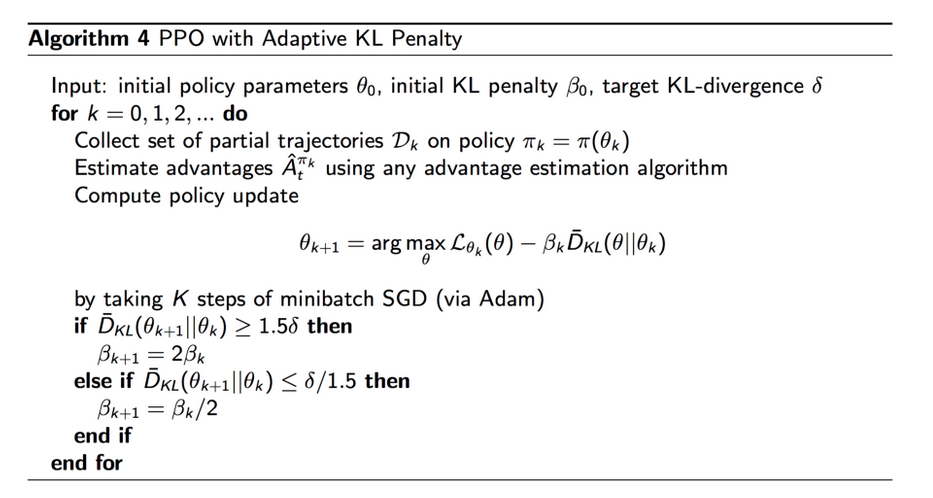

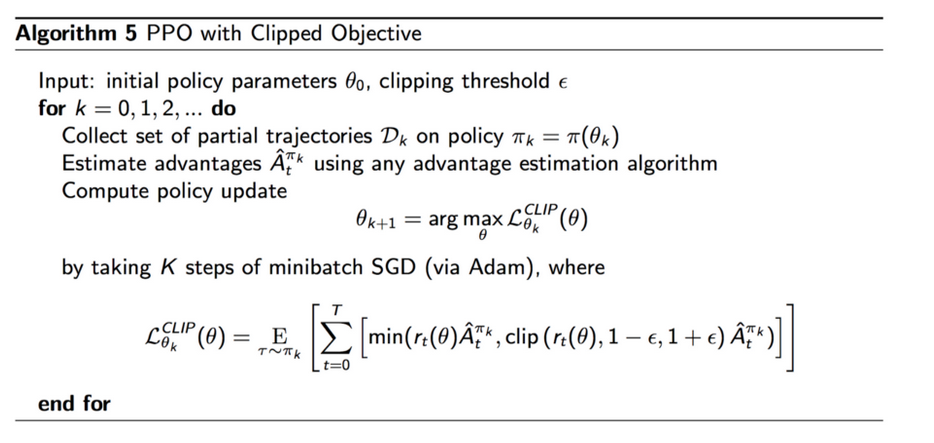

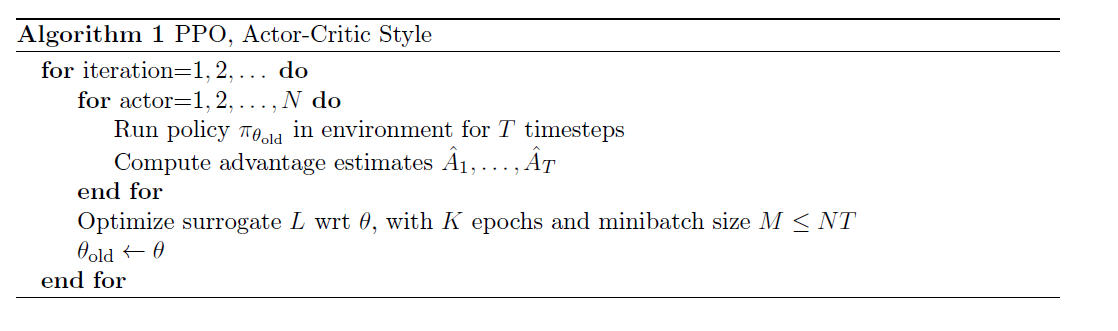

Based on the literature we will implement the best performance algo which is the clipped objective version

Reference: https://colab.research.google.com/github/nikhilbarhate99/PPO-PyTorch/blob/master/PPO_colab.ipynb#scrollTo=j5Rx_IFKHK-D

In [1]:
import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np
import pandas as pd

import gym
from machine import Machine
from GymMachEnv import MachineEnv
import matplotlib.pyplot as plt

In [7]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 128),
                            nn.Tanh(),
                            nn.Linear(128, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
#                             nn.Linear(state_dim, 64),
#                             nn.Tanh(),
#                             nn.Linear(64, 64),
#                             nn.Tanh(),
#                             nn.Linear(64, action_dim),
                
                            nn.Linear(state_dim,128),
                            nn.ReLU(),
                            nn.Linear(128,64),
                            nn.ReLU(),
                            nn.Linear(64,action_dim),
                            
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
#                         nn.Linear(state_dim, 64),
#                         nn.Tanh(),
#                         nn.Linear(64, 64),
#                         nn.Tanh(),
#                         nn.Linear(64, 1)
                            nn.Linear(state_dim,128),
                            nn.ReLU(),
                            nn.Linear(128,64),
                            nn.ReLU(),
                            nn.Linear(64,1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach()
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach()
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach()

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       

In [8]:
################ PPO hyperparameters ################
has_continuous_action_space = False
max_ep_len = 400                    # max timesteps in one episode
max_training_timesteps = int(1e6)   # break training loop if timeteps > max_training_timesteps
update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor
action_std = None

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)


print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)
#####################################################

In [9]:
###################################Initialise Env###########################
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [10]:
####################################Set Random Seed##########################
# print("setting random seed to ", random_seed)
# torch.manual_seed(random_seed)
# env.seed(random_seed)
# np.random.seed(random_seed)

In [11]:
# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, False, action_std)

In [12]:
# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")

# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0

tracker = []

checkpoint_path = 'ppo_agent_relu.pt'

# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

#         # log in logging file
#         if time_step % log_freq == 0:

#             # log average reward till last episode
#             log_avg_reward = log_running_reward / log_running_episodes
#             log_avg_reward = round(log_avg_reward, 4)

#             log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
#             log_f.flush()

#             log_running_reward = 0
#             log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)
            tracker.append([i_episode,print_avg_reward])
            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

#     log_running_reward += current_ep_reward
#     log_running_episodes += 1

    i_episode += 1


# log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

Started training at (GMT) :  2021-12-31 14:26:37
Episode : 28 		 Timestep : 1600 		 Average Reward : 26075.0
Episode : 58 		 Timestep : 3200 		 Average Reward : 22530.0
Episode : 84 		 Timestep : 4800 		 Average Reward : 29676.92
Episode : 121 		 Timestep : 6400 		 Average Reward : 21381.08
Episode : 158 		 Timestep : 8000 		 Average Reward : 21167.57
Episode : 202 		 Timestep : 9600 		 Average Reward : 18493.18
Episode : 239 		 Timestep : 11200 		 Average Reward : 19608.11
Episode : 279 		 Timestep : 12800 		 Average Reward : 18492.5
Episode : 316 		 Timestep : 14400 		 Average Reward : 21316.22
Episode : 350 		 Timestep : 16000 		 Average Reward : 20567.65
Episode : 380 		 Timestep : 17600 		 Average Reward : 23126.67
Episode : 419 		 Timestep : 19200 		 Average Reward : 19589.74
--------------------------------------------------------------------------------------------
saving model at : ppo_agent_relu.pt
model saved
Elapsed Time  :  0:00:39
-----------------------------------------

Episode : 3333 		 Timestep : 158400 		 Average Reward : 24352.78
Episode : 3362 		 Timestep : 160000 		 Average Reward : 28203.45
--------------------------------------------------------------------------------------------
saving model at : ppo_agent_relu.pt
model saved
Elapsed Time  :  0:05:11
--------------------------------------------------------------------------------------------
Episode : 3399 		 Timestep : 161600 		 Average Reward : 22724.32
Episode : 3445 		 Timestep : 163200 		 Average Reward : 18365.22
Episode : 3478 		 Timestep : 164800 		 Average Reward : 26645.45
Episode : 3516 		 Timestep : 166400 		 Average Reward : 21471.05
Episode : 3556 		 Timestep : 168000 		 Average Reward : 21295.0
Episode : 3586 		 Timestep : 169600 		 Average Reward : 29433.33
Episode : 3623 		 Timestep : 171200 		 Average Reward : 24954.05
Episode : 3656 		 Timestep : 172800 		 Average Reward : 25745.45
Episode : 3692 		 Timestep : 174400 		 Average Reward : 23250.0
Episode : 3727 		 Timestep :

Episode : 6421 		 Timestep : 310400 		 Average Reward : 29317.24
Episode : 6453 		 Timestep : 312000 		 Average Reward : 25696.88
Episode : 6489 		 Timestep : 313600 		 Average Reward : 21261.11
Episode : 6519 		 Timestep : 315200 		 Average Reward : 28343.33
Episode : 6553 		 Timestep : 316800 		 Average Reward : 24355.88
Episode : 6578 		 Timestep : 318400 		 Average Reward : 32680.0
Episode : 6616 		 Timestep : 320000 		 Average Reward : 21755.26
--------------------------------------------------------------------------------------------
saving model at : ppo_agent_relu.pt
model saved
Elapsed Time  :  0:10:29
--------------------------------------------------------------------------------------------
Episode : 6644 		 Timestep : 321600 		 Average Reward : 30414.29
Episode : 6682 		 Timestep : 323200 		 Average Reward : 20560.53
Episode : 6733 		 Timestep : 324800 		 Average Reward : 17254.9
Episode : 6767 		 Timestep : 326400 		 Average Reward : 24994.12
Episode : 6795 		 Timestep :

Episode : 9553 		 Timestep : 462400 		 Average Reward : 26743.75
Episode : 9585 		 Timestep : 464000 		 Average Reward : 28221.88
Episode : 9622 		 Timestep : 465600 		 Average Reward : 22208.11
Episode : 9654 		 Timestep : 467200 		 Average Reward : 24425.0
Episode : 9685 		 Timestep : 468800 		 Average Reward : 28438.71
Episode : 9720 		 Timestep : 470400 		 Average Reward : 23714.29
Episode : 9753 		 Timestep : 472000 		 Average Reward : 25572.73
Episode : 9784 		 Timestep : 473600 		 Average Reward : 28625.81
Episode : 9814 		 Timestep : 475200 		 Average Reward : 28336.67
Episode : 9855 		 Timestep : 476800 		 Average Reward : 20429.27
Episode : 9888 		 Timestep : 478400 		 Average Reward : 25036.36
Episode : 9919 		 Timestep : 480000 		 Average Reward : 27858.06
--------------------------------------------------------------------------------------------
saving model at : ppo_agent_relu.pt
model saved
Elapsed Time  :  0:16:26
-------------------------------------------------------

Episode : 12692 		 Timestep : 619200 		 Average Reward : 27809.09
--------------------------------------------------------------------------------------------
saving model at : ppo_agent_relu.pt
model saved
Elapsed Time  :  0:22:17
--------------------------------------------------------------------------------------------
Episode : 12724 		 Timestep : 620800 		 Average Reward : 27134.38
Episode : 12761 		 Timestep : 622400 		 Average Reward : 24491.89
Episode : 12792 		 Timestep : 624000 		 Average Reward : 26219.35
Episode : 12830 		 Timestep : 625600 		 Average Reward : 23731.58
Episode : 12856 		 Timestep : 627200 		 Average Reward : 35373.08
Episode : 12896 		 Timestep : 628800 		 Average Reward : 23102.5
Episode : 12925 		 Timestep : 630400 		 Average Reward : 29620.69
Episode : 12967 		 Timestep : 632000 		 Average Reward : 20826.19
Episode : 12997 		 Timestep : 633600 		 Average Reward : 27996.67
Episode : 13029 		 Timestep : 635200 		 Average Reward : 27618.75
Episode : 13059 

Episode : 15576 		 Timestep : 768000 		 Average Reward : 33367.86
Episode : 15606 		 Timestep : 769600 		 Average Reward : 28956.67
Episode : 15640 		 Timestep : 771200 		 Average Reward : 25408.82
Episode : 15677 		 Timestep : 772800 		 Average Reward : 24281.08
Episode : 15705 		 Timestep : 774400 		 Average Reward : 30214.29
Episode : 15737 		 Timestep : 776000 		 Average Reward : 28078.12
Episode : 15771 		 Timestep : 777600 		 Average Reward : 24132.35
Episode : 15794 		 Timestep : 779200 		 Average Reward : 37743.48
--------------------------------------------------------------------------------------------
saving model at : ppo_agent_relu.pt
model saved
Elapsed Time  :  0:29:10
--------------------------------------------------------------------------------------------
Episode : 15826 		 Timestep : 780800 		 Average Reward : 24840.62
Episode : 15850 		 Timestep : 782400 		 Average Reward : 32591.67
Episode : 15884 		 Timestep : 784000 		 Average Reward : 26879.41
Episode : 15917

Episode : 18569 		 Timestep : 921600 		 Average Reward : 31888.89
Episode : 18603 		 Timestep : 923200 		 Average Reward : 26458.82
Episode : 18635 		 Timestep : 924800 		 Average Reward : 26512.5
Episode : 18670 		 Timestep : 926400 		 Average Reward : 24042.86
Episode : 18697 		 Timestep : 928000 		 Average Reward : 32848.15
Episode : 18734 		 Timestep : 929600 		 Average Reward : 22540.54
Episode : 18762 		 Timestep : 931200 		 Average Reward : 31146.43
Episode : 18799 		 Timestep : 932800 		 Average Reward : 22959.46
Episode : 18827 		 Timestep : 934400 		 Average Reward : 30814.29
Episode : 18860 		 Timestep : 936000 		 Average Reward : 25687.88
Episode : 18895 		 Timestep : 937600 		 Average Reward : 26348.57
Episode : 18931 		 Timestep : 939200 		 Average Reward : 23250.0
--------------------------------------------------------------------------------------------
saving model at : ppo_agent_relu.pt
model saved
Elapsed Time  :  0:35:12
--------------------------------------------

Text(0.5, 1.0, 'PPO Clipped Objective, Layer: (128,64), Activation: Tanh')

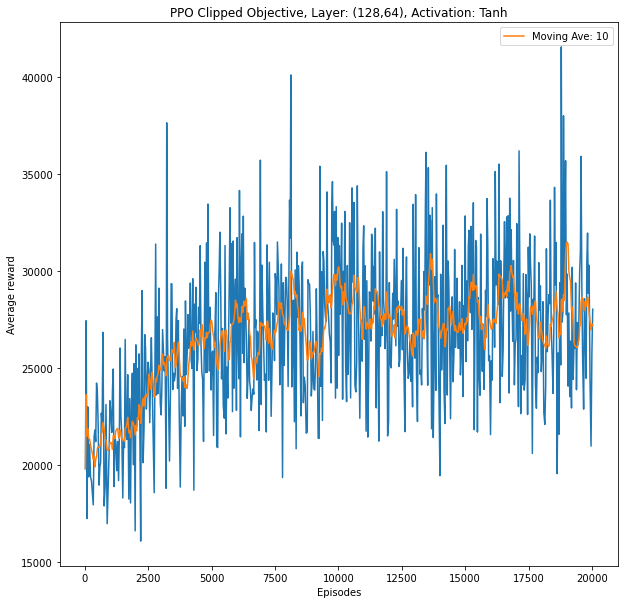

In [74]:
tracker_plt_tahn_v2 = np.array(tracker)
df = pd.DataFrame(tracker_plt_tahn_v2)
moving_ave = df.iloc[:,1].rolling(10,min_periods=1).mean().values.flatten().tolist()

fig = plt.figure(figsize=(10,10))
plt.plot(tracker_plt_tahn_v2[:,0],tracker_plt_tahn_v2[:,1])
plt.plot(tracker_plt_tahn_v2[:,0],moving_ave,label='Moving Ave: 10')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.title('PPO Clipped Objective, Layer: (128,64), Activation: Tanh')

Text(0.5, 1.0, 'PPO Clipped Objective, Layer: (128,64), Activation: ReLU')

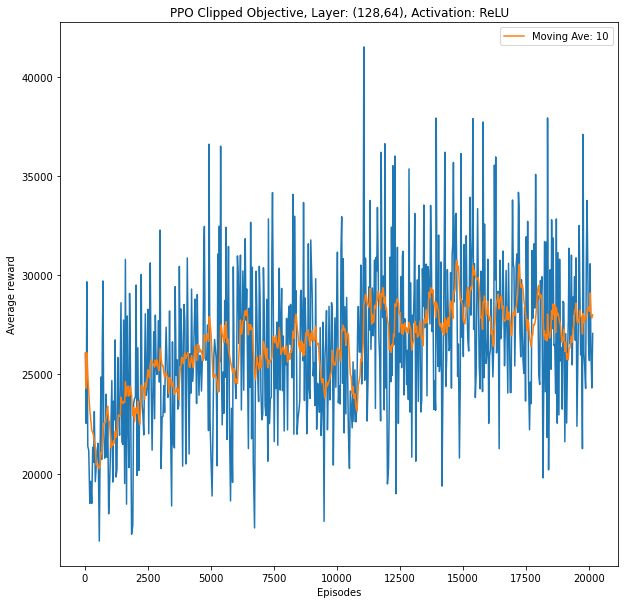

In [13]:
tracker_plt_relu_v2 = np.array(tracker)
df = pd.DataFrame(tracker_plt_relu_v2)
moving_ave = df.iloc[:,1].rolling(10,min_periods=1).mean().values.flatten().tolist()

fig = plt.figure(figsize=(10,10))
plt.plot(tracker_plt_relu_v2[:,0],tracker_plt_relu_v2[:,1])
plt.plot(tracker_plt_relu_v2[:,0],moving_ave,label='Moving Ave: 10')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.title('PPO Clipped Objective, Layer: (128,64), Activation: ReLU')

Text(0.5, 1.0, 'PPO Clipped Objective, Layer: (64,64), Activation: ReLU')

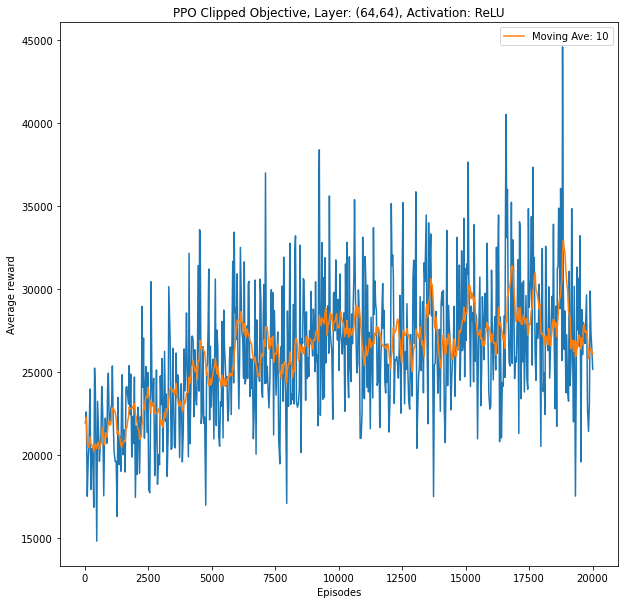

In [59]:
tracker_plt_relu = np.array(tracker)
df = pd.DataFrame(tracker_plt_relu)
moving_ave = df.iloc[:,1].rolling(10,min_periods=1).mean().values.flatten().tolist()

fig = plt.figure(figsize=(10,10))
plt.plot(tracker_plt_relu[:,0],tracker_plt_relu[:,1])
plt.plot(tracker_plt_relu[:,0],moving_ave,label='Moving Ave: 10')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.title('PPO Clipped Objective, Layer: (64,64), Activation: ReLU')

Text(0.5, 1.0, 'PPO Clipped Objective, Layer: (64,64), Activation: Tahn')

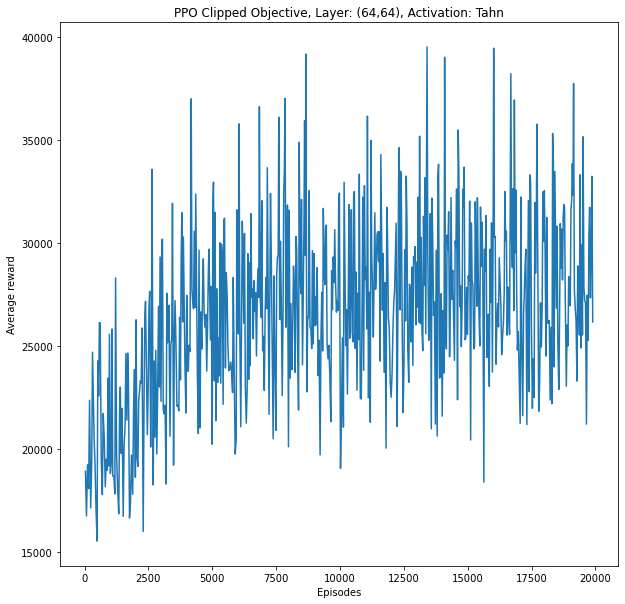

In [38]:
tracker_plt_tahn = np.array(tracker)
fig = plt.figure(figsize=(10,10))
plt.plot(tracker_plt_tahn[:,0],tracker_plt_tahn[:,1])
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.title('PPO Clipped Objective, Layer: (64,64), Activation: Tahn')

# Baseline Library

In [3]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common import make_vec_env
from stable_baselines import PPO1,PPO2
import tensorflow as tf
from stable_baselines.common.callbacks import EvalCallback
import gym
from machine import Machine
from GymMachEnv import MachineEnv

C:\Users\overl\anaconda3\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\overl\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\overl\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=Tru

In [4]:
# multiprocess environment
env = make_vec_env('CartPole-v1', n_envs=4)

model = PPO2(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=25000)
model.save("ppo2_cartpole")

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



--------------------------------------
| approxkl           | 9.8694014e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 23.1          |
| ep_reward_mean     | 23.1          |
| explained_variance | 0.0108        |
| fps                | 2064          |
| n_updates          | 1             |
| policy_entropy     | 0.6930429     |
| policy_loss        | -0.0011025243 |
| serial_timesteps   | 128           |
| time_elapsed       | 0             |
| total_timesteps    | 512           |
| value_loss         | 46.354965     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00018814755 |
| clipfrac           | 0.0           |
| ep_len_mean        | 23.4          |
| ep_reward_mean     | 

--------------------------------------
| approxkl           | 0.00047789293 |
| clipfrac           | 0.0           |
| ep_len_mean        | 34.6          |
| ep_reward_mean     | 34.6          |
| explained_variance | 0.0153        |
| fps                | 5703          |
| n_updates          | 11            |
| policy_entropy     | 0.6420948     |
| policy_loss        | -0.001292222  |
| serial_timesteps   | 1408          |
| time_elapsed       | 1.07          |
| total_timesteps    | 5632          |
| value_loss         | 61.212498     |
--------------------------------------
--------------------------------------
| approxkl           | 8.0832426e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 37            |
| ep_reward_mean     | 37            |
| explained_variance | 0.00206       |
| fps                | 6160          |
| n_updates          | 12            |
| policy_entropy     | 0.64150894    |
| policy_loss        | -0.0013636454 |
| serial_timesteps   | 15

--------------------------------------
| approxkl           | 0.00036862883 |
| clipfrac           | 0.0009765625  |
| ep_len_mean        | 72.3          |
| ep_reward_mean     | 72.3          |
| explained_variance | 0.0823        |
| fps                | 5782          |
| n_updates          | 26            |
| policy_entropy     | 0.58962303    |
| policy_loss        | -0.0035946853 |
| serial_timesteps   | 3328          |
| time_elapsed       | 2.41          |
| total_timesteps    | 13312         |
| value_loss         | 78.07503      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00049787754 |
| clipfrac           | 0.0           |
| ep_len_mean        | 74            |
| ep_reward_mean     | 74            |
| explained_variance | -0.0363       |
| fps                | 5770          |
| n_updates          | 27            |
| policy_entropy     | 0.59178       |
| policy_loss        | 0.00050190376 |
| serial_timesteps   | 34

--------------------------------------
| approxkl           | 4.7704118e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 133           |
| ep_reward_mean     | 133           |
| explained_variance | 0.105         |
| fps                | 6056          |
| n_updates          | 41            |
| policy_entropy     | 0.5632957     |
| policy_loss        | -7.205177e-05 |
| serial_timesteps   | 5248          |
| time_elapsed       | 3.75          |
| total_timesteps    | 20992         |
| value_loss         | 72.078545     |
--------------------------------------
---------------------------------------
| approxkl           | 1.1036095e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 135            |
| ep_reward_mean     | 135            |
| explained_variance | 0.0223         |
| fps                | 6336           |
| n_updates          | 42             |
| policy_entropy     | 0.5627675      |
| policy_loss        | -3.9697625e-07 |
| serial_timest

In [5]:
machine = Machine()
machine.curr_state = 0
env = DummyVecEnv([lambda: MachineEnv(machine)])

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[128,64,dict(vf=[128,64], pi=[128,64])])
machine2 = Machine()
machine2.curr_state = 0
eval_env = DummyVecEnv([lambda: MachineEnv(machine2)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./best/trial',
                             log_path='./best/trial', eval_freq=500,
                             deterministic=True, render=False)
model = PPO2('MlpPolicy',env,verbose=1, tensorboard_log="./PPO_GMM_tensorboard/",policy_kwargs= policy_kwargs,noptepochs=40).learn(total_timesteps=200000,callback=eval_callback)



--------------------------------------
| approxkl           | 5.8553163e-05 |
| clipfrac           | 0.0           |
| explained_variance | -4.77e-07     |
| fps                | 157           |
| n_updates          | 1             |
| policy_entropy     | 0.6930869     |
| policy_loss        | -0.0009421272 |
| serial_timesteps   | 128           |
| time_elapsed       | 0             |
| total_timesteps    | 128           |
| value_loss         | 12108865.0    |
--------------------------------------
-------------------------------------
| approxkl           | 0.013204699  |
| clipfrac           | 0.13886718   |
| explained_variance | 2.98e-07     |
| fps                | 204          |
| n_updates          | 2            |
| policy_entropy     | 0.6778294    |
| policy_loss        | -0.013447406 |
| serial_timesteps   | 256          |
| time_elapsed       | 0.816        |
| total_timesteps    | 256          |
| value_loss         | 26072252.0   |
-----------------------------------

Eval num_timesteps=2000, episode_reward=6360.00 +/- 3681.63
Episode length: 12.80 +/- 4.07
--------------------------------------
| approxkl           | 3.9175204e-05 |
| clipfrac           | 0.0           |
| explained_variance | -3.22e-06     |
| fps                | 180           |
| n_updates          | 16            |
| policy_entropy     | 0.44728732    |
| policy_loss        | 0.0010178041  |
| serial_timesteps   | 2048          |
| time_elapsed       | 9.46          |
| total_timesteps    | 2048          |
| value_loss         | 8096290.5     |
--------------------------------------
---------------------------------------
| approxkl           | 4.1011568e-05  |
| clipfrac           | 0.0            |
| explained_variance | 6.62e-06       |
| fps                | 234            |
| n_updates          | 17             |
| policy_entropy     | 0.446215       |
| policy_loss        | -0.00022742234 |
| serial_timesteps   | 2176           |
| time_elapsed       | 10.2           |
| 

Eval num_timesteps=4000, episode_reward=2460.00 +/- 2671.03
Episode length: 8.20 +/- 3.66
--------------------------------------
| approxkl           | 1.0111466e-05 |
| clipfrac           | 0.0           |
| explained_variance | 6.29e-05      |
| fps                | 189           |
| n_updates          | 32            |
| policy_entropy     | 0.4611296     |
| policy_loss        | 1.7691136e-05 |
| serial_timesteps   | 4096          |
| time_elapsed       | 19.1          |
| total_timesteps    | 4096          |
| value_loss         | 9350585.0     |
--------------------------------------
--------------------------------------
| approxkl           | 7.5475473e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00012       |
| fps                | 227           |
| n_updates          | 33            |
| policy_entropy     | 0.4625594     |
| policy_loss        | 0.00020682506 |
| serial_timesteps   | 4224          |
| time_elapsed       | 19.8          |
| total_times

--------------------------------------
| approxkl           | 8.957239e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.000229      |
| fps                | 189           |
| n_updates          | 48            |
| policy_entropy     | 0.23549275    |
| policy_loss        | 0.00021873403 |
| serial_timesteps   | 6144          |
| time_elapsed       | 29.5          |
| total_timesteps    | 6144          |
| value_loss         | 9640932.0     |
--------------------------------------
-------------------------------------
| approxkl           | 6.797754e-06 |
| clipfrac           | 0.0          |
| explained_variance | 0.000413     |
| fps                | 201          |
| n_updates          | 49           |
| policy_entropy     | 0.23875777   |
| policy_loss        | 0.0002812902 |
| serial_timesteps   | 6272         |
| time_elapsed       | 30.2         |
| total_timesteps    | 6272         |
| value_loss         | 3201131.0    |
-------------------------------------

-------------------------------------
| approxkl           | 0.015039248  |
| clipfrac           | 0.23359375   |
| explained_variance | 6.84e-05     |
| fps                | 200          |
| n_updates          | 64           |
| policy_entropy     | 0.6702051    |
| policy_loss        | 0.0154383825 |
| serial_timesteps   | 8192         |
| time_elapsed       | 40.5         |
| total_timesteps    | 8192         |
| value_loss         | 14245234.0   |
-------------------------------------
-------------------------------------
| approxkl           | 0.011654964  |
| clipfrac           | 0.08203125   |
| explained_variance | 7.72e-05     |
| fps                | 202          |
| n_updates          | 65           |
| policy_entropy     | 0.6923886    |
| policy_loss        | 0.0116274115 |
| serial_timesteps   | 8320         |
| time_elapsed       | 41.1         |
| total_timesteps    | 8320         |
| value_loss         | 14838987.0   |
-------------------------------------
------------

--------------------------------------
| approxkl           | 2.8615918e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.000125      |
| fps                | 205           |
| n_updates          | 80            |
| policy_entropy     | 0.5790578     |
| policy_loss        | 0.00015594708 |
| serial_timesteps   | 10240         |
| time_elapsed       | 51.1          |
| total_timesteps    | 10240         |
| value_loss         | 18536096.0    |
--------------------------------------
--------------------------------------
| approxkl           | 0.0005922771  |
| clipfrac           | 0.0           |
| explained_variance | 0.000302      |
| fps                | 202           |
| n_updates          | 81            |
| policy_entropy     | 0.58334863    |
| policy_loss        | -0.0018552414 |
| serial_timesteps   | 10368         |
| time_elapsed       | 51.7          |
| total_timesteps    | 10368         |
| value_loss         | 23360632.0    |
-------------------------

--------------------------------------
| approxkl           | 3.5082976e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.000223      |
| fps                | 208           |
| n_updates          | 96            |
| policy_entropy     | 0.44126576    |
| policy_loss        | 6.600454e-05  |
| serial_timesteps   | 12288         |
| time_elapsed       | 61.5          |
| total_timesteps    | 12288         |
| value_loss         | 20775164.0    |
--------------------------------------
---------------------------------------
| approxkl           | 3.6457427e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.000181       |
| fps                | 207            |
| n_updates          | 97             |
| policy_entropy     | 0.44252864     |
| policy_loss        | -0.00018758603 |
| serial_timesteps   | 12416          |
| time_elapsed       | 62.1           |
| total_timesteps    | 12416          |
| value_loss         | 11536779.0     |
-------------

--------------------------------------
| approxkl           | 3.2597595e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.000611      |
| fps                | 204           |
| n_updates          | 112           |
| policy_entropy     | 0.21449006    |
| policy_loss        | 0.00012543696 |
| serial_timesteps   | 14336         |
| time_elapsed       | 72.2          |
| total_timesteps    | 14336         |
| value_loss         | 10295762.0    |
--------------------------------------
--------------------------------------
| approxkl           | 5.49166e-06   |
| clipfrac           | 0.0           |
| explained_variance | 0.000318      |
| fps                | 203           |
| n_updates          | 113           |
| policy_entropy     | 0.20298608    |
| policy_loss        | 0.00018296656 |
| serial_timesteps   | 14464         |
| time_elapsed       | 72.8          |
| total_timesteps    | 14464         |
| value_loss         | 8591764.0     |
-------------------------

--------------------------------------
| approxkl           | 4.732117e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00132       |
| fps                | 201           |
| n_updates          | 128           |
| policy_entropy     | 0.21085966    |
| policy_loss        | -0.0001283687 |
| serial_timesteps   | 16384         |
| time_elapsed       | 82.8          |
| total_timesteps    | 16384         |
| value_loss         | 12543734.0    |
--------------------------------------
Eval num_timesteps=16500, episode_reward=3820.00 +/- 3982.16
Episode length: 8.80 +/- 6.62
----------------------------------------
| approxkl           | 2.581855e-06    |
| clipfrac           | 0.0             |
| explained_variance | 0.00121         |
| fps                | 167             |
| n_updates          | 129             |
| policy_entropy     | 0.21427202      |
| policy_loss        | -0.000106978194 |
| serial_timesteps   | 16512           |
| time_elapsed       | 83.5      

--------------------------------------
| approxkl           | 2.2655757e-05 |
| clipfrac           | 0.0           |
| explained_variance | 0.00198       |
| fps                | 196           |
| n_updates          | 144           |
| policy_entropy     | 0.2331495     |
| policy_loss        | -0.0011678879 |
| serial_timesteps   | 18432         |
| time_elapsed       | 93.9          |
| total_timesteps    | 18432         |
| value_loss         | 10413351.0    |
--------------------------------------
Eval num_timesteps=18500, episode_reward=8600.00 +/- 8021.72
Episode length: 15.80 +/- 10.38
---------------------------------------
| approxkl           | 1.367359e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.00113        |
| fps                | 151            |
| n_updates          | 145            |
| policy_entropy     | 0.23373675     |
| policy_loss        | -0.00018870886 |
| serial_timesteps   | 18560          |
| time_elapsed       | 94.5           |


--------------------------------------
| approxkl           | 0.00018710134 |
| clipfrac           | 0.0           |
| explained_variance | 0.00102       |
| fps                | 198           |
| n_updates          | 160           |
| policy_entropy     | 0.27508274    |
| policy_loss        | -0.0033829666 |
| serial_timesteps   | 20480         |
| time_elapsed       | 105           |
| total_timesteps    | 20480         |
| value_loss         | 10199934.0    |
--------------------------------------
Eval num_timesteps=20500, episode_reward=6400.00 +/- 5278.26
Episode length: 13.40 +/- 7.76
-------------------------------------
| approxkl           | 4.374354e-05 |
| clipfrac           | 0.0          |
| explained_variance | 0.00401      |
| fps                | 157          |
| n_updates          | 161          |
| policy_entropy     | 0.3064614    |
| policy_loss        | -0.000931374 |
| serial_timesteps   | 20608        |
| time_elapsed       | 106          |
| total_timesteps    

Eval num_timesteps=22500, episode_reward=4960.00 +/- 2926.16
Episode length: 11.00 +/- 4.86
---------------------------------------
| approxkl           | 1.9196173e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00206        |
| fps                | 155            |
| n_updates          | 176            |
| policy_entropy     | 0.26428896     |
| policy_loss        | -3.9846713e-05 |
| serial_timesteps   | 22528          |
| time_elapsed       | 117            |
| total_timesteps    | 22528          |
| value_loss         | 14220742.0     |
---------------------------------------
---------------------------------------
| approxkl           | 3.6144622e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00214        |
| fps                | 192            |
| n_updates          | 177            |
| policy_entropy     | 0.26266342     |
| policy_loss        | -0.00016946874 |
| serial_timesteps   | 22656          |
| time_elapsed       | 117  

Eval num_timesteps=24500, episode_reward=2860.00 +/- 2728.08
Episode length: 8.40 +/- 4.18
---------------------------------------
| approxkl           | 1.5826345e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00378        |
| fps                | 161            |
| n_updates          | 192            |
| policy_entropy     | 0.268899       |
| policy_loss        | -0.00017410274 |
| serial_timesteps   | 24576          |
| time_elapsed       | 128            |
| total_timesteps    | 24576          |
| value_loss         | 5971962.0      |
---------------------------------------
--------------------------------------
| approxkl           | 2.120929e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00123       |
| fps                | 183           |
| n_updates          | 193           |
| policy_entropy     | 0.25796205    |
| policy_loss        | 0.00016147051 |
| serial_timesteps   | 24704         |
| time_elapsed       | 129           |

Eval num_timesteps=26500, episode_reward=6260.00 +/- 1791.76
Episode length: 12.60 +/- 2.06
--------------------------------------
| approxkl           | 8.599725e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00198       |
| fps                | 153           |
| n_updates          | 208           |
| policy_entropy     | 0.29775938    |
| policy_loss        | -0.0005822404 |
| serial_timesteps   | 26624         |
| time_elapsed       | 140           |
| total_timesteps    | 26624         |
| value_loss         | 17472324.0    |
--------------------------------------
--------------------------------------
| approxkl           | 1.2277997e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00111       |
| fps                | 189           |
| n_updates          | 209           |
| policy_entropy     | 0.2936454     |
| policy_loss        | -7.091613e-05 |
| serial_timesteps   | 26752         |
| time_elapsed       | 141           |
| total_tim

--------------------------------------
| approxkl           | 3.5237986e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00365       |
| fps                | 191           |
| n_updates          | 224           |
| policy_entropy     | 0.33157617    |
| policy_loss        | -0.0001827013 |
| serial_timesteps   | 28672         |
| time_elapsed       | 151           |
| total_timesteps    | 28672         |
| value_loss         | 9208686.0     |
--------------------------------------
--------------------------------------
| approxkl           | 6.9635206e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.00244       |
| fps                | 186           |
| n_updates          | 225           |
| policy_entropy     | 0.34645703    |
| policy_loss        | -9.261265e-05 |
| serial_timesteps   | 28800         |
| time_elapsed       | 152           |
| total_timesteps    | 28800         |
| value_loss         | 11971845.0    |
-------------------------

--------------------------------------
| approxkl           | 1.8818104e-05 |
| clipfrac           | 0.0           |
| explained_variance | 0.00442       |
| fps                | 125           |
| n_updates          | 240           |
| policy_entropy     | 0.59762037    |
| policy_loss        | -0.0005029608 |
| serial_timesteps   | 30720         |
| time_elapsed       | 164           |
| total_timesteps    | 30720         |
| value_loss         | 11004774.0    |
--------------------------------------
--------------------------------------
| approxkl           | 0.0027717748  |
| clipfrac           | 0.045703124   |
| explained_variance | -0.000254     |
| fps                | 127           |
| n_updates          | 241           |
| policy_entropy     | 0.6054784     |
| policy_loss        | -0.0006320352 |
| serial_timesteps   | 30848         |
| time_elapsed       | 165           |
| total_timesteps    | 30848         |
| value_loss         | 15986822.0    |
-------------------------

-------------------------------------
| approxkl           | 1.737753e-06 |
| clipfrac           | 0.0          |
| explained_variance | 0.00499      |
| fps                | 169          |
| n_updates          | 256          |
| policy_entropy     | 0.42788738   |
| policy_loss        | 4.849511e-05 |
| serial_timesteps   | 32768        |
| time_elapsed       | 178          |
| total_timesteps    | 32768        |
| value_loss         | 10646822.0   |
-------------------------------------
-------------------------------------
| approxkl           | 6.103286e-07 |
| clipfrac           | 0.0          |
| explained_variance | 0.000745     |
| fps                | 169          |
| n_updates          | 257          |
| policy_entropy     | 0.4163248    |
| policy_loss        | 5.061829e-05 |
| serial_timesteps   | 32896        |
| time_elapsed       | 179          |
| total_timesteps    | 32896        |
| value_loss         | 26942556.0   |
-------------------------------------
Eval num_tim

---------------------------------------
| approxkl           | 3.1990287e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00341        |
| fps                | 123            |
| n_updates          | 272            |
| policy_entropy     | 0.4717577      |
| policy_loss        | -0.00018992354 |
| serial_timesteps   | 34816          |
| time_elapsed       | 191            |
| total_timesteps    | 34816          |
| value_loss         | 26682720.0     |
---------------------------------------
---------------------------------------
| approxkl           | 1.4036451e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00756        |
| fps                | 152            |
| n_updates          | 273            |
| policy_entropy     | 0.47763833     |
| policy_loss        | -0.00019777454 |
| serial_timesteps   | 34944          |
| time_elapsed       | 192            |
| total_timesteps    | 34944          |
| value_loss         | 5718273.0      |


--------------------------------------
| approxkl           | 7.0665084e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.00885       |
| fps                | 134           |
| n_updates          | 288           |
| policy_entropy     | 0.26782715    |
| policy_loss        | -7.72032e-06  |
| serial_timesteps   | 36864         |
| time_elapsed       | 206           |
| total_timesteps    | 36864         |
| value_loss         | 6984864.0     |
--------------------------------------
--------------------------------------
| approxkl           | 1.8009275e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00363       |
| fps                | 139           |
| n_updates          | 289           |
| policy_entropy     | 0.27545798    |
| policy_loss        | 5.5461678e-05 |
| serial_timesteps   | 36992         |
| time_elapsed       | 207           |
| total_timesteps    | 36992         |
| value_loss         | 8690483.0     |
-------------------------

---------------------------------------
| approxkl           | 1.6899842e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00479        |
| fps                | 171            |
| n_updates          | 304            |
| policy_entropy     | 0.2748198      |
| policy_loss        | -0.00012294055 |
| serial_timesteps   | 38912          |
| time_elapsed       | 219            |
| total_timesteps    | 38912          |
| value_loss         | 9164426.0      |
---------------------------------------
Eval num_timesteps=39000, episode_reward=6940.00 +/- 4851.64
Episode length: 12.00 +/- 4.52
---------------------------------------
| approxkl           | 1.255891e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.00553        |
| fps                | 139            |
| n_updates          | 305            |
| policy_entropy     | 0.27819115     |
| policy_loss        | -0.00013993548 |
| serial_timesteps   | 39040          |
| time_elapsed       | 220  

---------------------------------------
| approxkl           | 9.621211e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0041         |
| fps                | 161            |
| n_updates          | 320            |
| policy_entropy     | 0.30496582     |
| policy_loss        | -0.00012472917 |
| serial_timesteps   | 40960          |
| time_elapsed       | 232            |
| total_timesteps    | 40960          |
| value_loss         | 7537109.0      |
---------------------------------------
Eval num_timesteps=41000, episode_reward=4660.00 +/- 4553.06
Episode length: 10.60 +/- 5.75
--------------------------------------
| approxkl           | 5.1472207e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00343       |
| fps                | 138           |
| n_updates          | 321           |
| policy_entropy     | 0.31373906    |
| policy_loss        | 0.00021833535 |
| serial_timesteps   | 41088         |
| time_elapsed       | 233           

Eval num_timesteps=43000, episode_reward=8780.00 +/- 4860.21
Episode length: 15.60 +/- 5.54
--------------------------------------
| approxkl           | 3.2853928e-05 |
| clipfrac           | 0.0           |
| explained_variance | 0.00664       |
| fps                | 145           |
| n_updates          | 336           |
| policy_entropy     | 0.38594633    |
| policy_loss        | -0.0011889834 |
| serial_timesteps   | 43008         |
| time_elapsed       | 245           |
| total_timesteps    | 43008         |
| value_loss         | 11299110.0    |
--------------------------------------
---------------------------------------
| approxkl           | 1.6474775e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.000861       |
| fps                | 188            |
| n_updates          | 337            |
| policy_entropy     | 0.3966357      |
| policy_loss        | -5.3188607e-05 |
| serial_timesteps   | 43136          |
| time_elapsed       | 246            |
|

Eval num_timesteps=45000, episode_reward=5920.00 +/- 2056.60
Episode length: 13.20 +/- 3.31
---------------------------------------
| approxkl           | 1.1685026e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00786        |
| fps                | 128            |
| n_updates          | 352            |
| policy_entropy     | 0.43451127     |
| policy_loss        | -1.8660805e-05 |
| serial_timesteps   | 45056          |
| time_elapsed       | 257            |
| total_timesteps    | 45056          |
| value_loss         | 5150143.5      |
---------------------------------------
--------------------------------------
| approxkl           | 1.9679887e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00404       |
| fps                | 168           |
| n_updates          | 353           |
| policy_entropy     | 0.42684722    |
| policy_loss        | -8.183063e-05 |
| serial_timesteps   | 45184         |
| time_elapsed       | 258           

Eval num_timesteps=47000, episode_reward=1460.00 +/- 2484.83
Episode length: 5.60 +/- 3.93
------------------------------------
| approxkl           | 0.04550311  |
| clipfrac           | 0.49980468  |
| explained_variance | 0.00194     |
| fps                | 153         |
| n_updates          | 368         |
| policy_entropy     | 0.5650467   |
| policy_loss        | 0.016461106 |
| serial_timesteps   | 47104       |
| time_elapsed       | 271         |
| total_timesteps    | 47104       |
| value_loss         | 22381328.0  |
------------------------------------
--------------------------------------
| approxkl           | 0.00013157332 |
| clipfrac           | 0.0           |
| explained_variance | 0.00417       |
| fps                | 158           |
| n_updates          | 369           |
| policy_entropy     | 0.5184699     |
| policy_loss        | 9.685559e-05  |
| serial_timesteps   | 47232         |
| time_elapsed       | 271           |
| total_timesteps    | 47232         |

--------------------------------------
| approxkl           | 1.507175e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00487       |
| fps                | 173           |
| n_updates          | 384           |
| policy_entropy     | 0.42439947    |
| policy_loss        | 0.00010511793 |
| serial_timesteps   | 49152         |
| time_elapsed       | 284           |
| total_timesteps    | 49152         |
| value_loss         | 12940933.0    |
--------------------------------------
---------------------------------------
| approxkl           | 1.3068525e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00588        |
| fps                | 162            |
| n_updates          | 385            |
| policy_entropy     | 0.4197275      |
| policy_loss        | -2.4870102e-05 |
| serial_timesteps   | 49280          |
| time_elapsed       | 284            |
| total_timesteps    | 49280          |
| value_loss         | 8347210.5      |
-------------

--------------------------------------
| approxkl           | 9.598276e-05  |
| clipfrac           | 0.0001953125  |
| explained_variance | 0.00471       |
| fps                | 191           |
| n_updates          | 400           |
| policy_entropy     | 0.6161957     |
| policy_loss        | 0.00012608929 |
| serial_timesteps   | 51200         |
| time_elapsed       | 299           |
| total_timesteps    | 51200         |
| value_loss         | 18000044.0    |
--------------------------------------
-------------------------------------
| approxkl           | 0.016946202  |
| clipfrac           | 0.21601562   |
| explained_variance | -0.00304     |
| fps                | 177          |
| n_updates          | 401          |
| policy_entropy     | 0.50468385   |
| policy_loss        | -0.020379554 |
| serial_timesteps   | 51328        |
| time_elapsed       | 300          |
| total_timesteps    | 51328        |
| value_loss         | 14495288.0   |
-------------------------------------

--------------------------------------
| approxkl           | 4.6904907e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.00769       |
| fps                | 197           |
| n_updates          | 416           |
| policy_entropy     | 0.38558775    |
| policy_loss        | 3.4889497e-06 |
| serial_timesteps   | 53248         |
| time_elapsed       | 310           |
| total_timesteps    | 53248         |
| value_loss         | 7493162.5     |
--------------------------------------
--------------------------------------
| approxkl           | 8.3894486e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.017         |
| fps                | 192           |
| n_updates          | 417           |
| policy_entropy     | 0.39205152    |
| policy_loss        | 5.2798227e-05 |
| serial_timesteps   | 53376         |
| time_elapsed       | 311           |
| total_timesteps    | 53376         |
| value_loss         | 6399053.0     |
-------------------------

---------------------------------------
| approxkl           | 8.889199e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0027         |
| fps                | 192            |
| n_updates          | 432            |
| policy_entropy     | 0.18756178     |
| policy_loss        | -0.00013035547 |
| serial_timesteps   | 55296          |
| time_elapsed       | 321            |
| total_timesteps    | 55296          |
| value_loss         | 8272953.5      |
---------------------------------------
--------------------------------------
| approxkl           | 1.392398e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0134        |
| fps                | 188           |
| n_updates          | 433           |
| policy_entropy     | 0.1762479     |
| policy_loss        | -7.757145e-05 |
| serial_timesteps   | 55424         |
| time_elapsed       | 322           |
| total_timesteps    | 55424         |
| value_loss         | 6302840.5     |
------------

--------------------------------------
| approxkl           | 3.2016353e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00901       |
| fps                | 193           |
| n_updates          | 448           |
| policy_entropy     | 0.18207762    |
| policy_loss        | -6.71792e-05  |
| serial_timesteps   | 57344         |
| time_elapsed       | 333           |
| total_timesteps    | 57344         |
| value_loss         | 8985501.0     |
--------------------------------------
--------------------------------------
| approxkl           | 1.4486764e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00089       |
| fps                | 192           |
| n_updates          | 449           |
| policy_entropy     | 0.20042014    |
| policy_loss        | 1.3583165e-06 |
| serial_timesteps   | 57472         |
| time_elapsed       | 334           |
| total_timesteps    | 57472         |
| value_loss         | 7400363.0     |
-------------------------

---------------------------------------
| approxkl           | 3.8265343e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0108         |
| fps                | 190            |
| n_updates          | 464            |
| policy_entropy     | 0.18577912     |
| policy_loss        | -1.3320125e-06 |
| serial_timesteps   | 59392          |
| time_elapsed       | 345            |
| total_timesteps    | 59392          |
| value_loss         | 5732245.5      |
---------------------------------------
Eval num_timesteps=59500, episode_reward=6640.00 +/- 3307.33
Episode length: 12.60 +/- 4.32
--------------------------------------
| approxkl           | 5.0442026e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.0156        |
| fps                | 153           |
| n_updates          | 465           |
| policy_entropy     | 0.18398848    |
| policy_loss        | 7.1428585e-05 |
| serial_timesteps   | 59520         |
| time_elapsed       | 345           

--------------------------------------
| approxkl           | 7.716032e-07  |
| clipfrac           | 0.0           |
| explained_variance | 0.0291        |
| fps                | 179           |
| n_updates          | 480           |
| policy_entropy     | 0.20643716    |
| policy_loss        | -7.294902e-05 |
| serial_timesteps   | 61440         |
| time_elapsed       | 357           |
| total_timesteps    | 61440         |
| value_loss         | 4636275.0     |
--------------------------------------
Eval num_timesteps=61500, episode_reward=6520.00 +/- 3876.80
Episode length: 12.60 +/- 5.78
---------------------------------------
| approxkl           | 2.2052413e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0159         |
| fps                | 141            |
| n_updates          | 481            |
| policy_entropy     | 0.20422868     |
| policy_loss        | -0.00019301128 |
| serial_timesteps   | 61568          |
| time_elapsed       | 357            |
|

---------------------------------------
| approxkl           | 1.0328103e-05  |
| clipfrac           | 0.0            |
| explained_variance | 0.0174         |
| fps                | 162            |
| n_updates          | 496            |
| policy_entropy     | 0.22067857     |
| policy_loss        | -0.00055833266 |
| serial_timesteps   | 63488          |
| time_elapsed       | 368            |
| total_timesteps    | 63488          |
| value_loss         | 7872564.0      |
---------------------------------------
Eval num_timesteps=63500, episode_reward=5440.00 +/- 3657.10
Episode length: 10.80 +/- 5.04
---------------------------------------
| approxkl           | 1.9369156e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00864        |
| fps                | 147            |
| n_updates          | 497            |
| policy_entropy     | 0.22304924     |
| policy_loss        | -0.00011789965 |
| serial_timesteps   | 63616          |
| time_elapsed       | 369  

Eval num_timesteps=65500, episode_reward=8480.00 +/- 3915.30
Episode length: 15.20 +/- 3.97
---------------------------------------
| approxkl           | 1.2191342e-05  |
| clipfrac           | 0.0            |
| explained_variance | 0.0128         |
| fps                | 143            |
| n_updates          | 512            |
| policy_entropy     | 0.30055642     |
| policy_loss        | -0.00036238442 |
| serial_timesteps   | 65536          |
| time_elapsed       | 380            |
| total_timesteps    | 65536          |
| value_loss         | 7443165.5      |
---------------------------------------
--------------------------------------
| approxkl           | 1.8007491e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00756       |
| fps                | 195           |
| n_updates          | 513           |
| policy_entropy     | 0.29881805    |
| policy_loss        | 7.1480856e-05 |
| serial_timesteps   | 65664         |
| time_elapsed       | 381           

Eval num_timesteps=67500, episode_reward=5400.00 +/- 3954.24
Episode length: 10.60 +/- 4.18
--------------------------------------
| approxkl           | 2.8012753e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0192        |
| fps                | 148           |
| n_updates          | 528           |
| policy_entropy     | 0.21148618    |
| policy_loss        | -7.394278e-05 |
| serial_timesteps   | 67584         |
| time_elapsed       | 392           |
| total_timesteps    | 67584         |
| value_loss         | 4950606.5     |
--------------------------------------
--------------------------------------
| approxkl           | 5.703816e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00923       |
| fps                | 180           |
| n_updates          | 529           |
| policy_entropy     | 0.22357628    |
| policy_loss        | 0.00031749377 |
| serial_timesteps   | 67712         |
| time_elapsed       | 392           |
| total_tim

---------------------------------------
| approxkl           | 5.0024328e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.02           |
| fps                | 188            |
| n_updates          | 544            |
| policy_entropy     | 0.21182463     |
| policy_loss        | -0.00027291002 |
| serial_timesteps   | 69632          |
| time_elapsed       | 403            |
| total_timesteps    | 69632          |
| value_loss         | 7569879.0      |
---------------------------------------
---------------------------------------
| approxkl           | 8.231322e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0237         |
| fps                | 191            |
| n_updates          | 545            |
| policy_entropy     | 0.21107888     |
| policy_loss        | -0.00060497795 |
| serial_timesteps   | 69760          |
| time_elapsed       | 404            |
| total_timesteps    | 69760          |
| value_loss         | 6830475.0      |


---------------------------------------
| approxkl           | 1.0538677e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0109         |
| fps                | 182            |
| n_updates          | 560            |
| policy_entropy     | 0.22685187     |
| policy_loss        | -1.6438109e-05 |
| serial_timesteps   | 71680          |
| time_elapsed       | 416            |
| total_timesteps    | 71680          |
| value_loss         | 15684195.0     |
---------------------------------------
--------------------------------------
| approxkl           | 2.3293828e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0161        |
| fps                | 189           |
| n_updates          | 561           |
| policy_entropy     | 0.22897401    |
| policy_loss        | 0.00014062822 |
| serial_timesteps   | 71808         |
| time_elapsed       | 416           |
| total_timesteps    | 71808         |
| value_loss         | 6889060.0     |
------------

--------------------------------------
| approxkl           | 0.00011217602 |
| clipfrac           | 0.0           |
| explained_variance | 0.0137        |
| fps                | 127           |
| n_updates          | 576           |
| policy_entropy     | 0.28518805    |
| policy_loss        | -0.0024327745 |
| serial_timesteps   | 73728         |
| time_elapsed       | 428           |
| total_timesteps    | 73728         |
| value_loss         | 21636518.0    |
--------------------------------------
--------------------------------------
| approxkl           | 9.440724e-05  |
| clipfrac           | 0.0           |
| explained_variance | 0.0141        |
| fps                | 154           |
| n_updates          | 577           |
| policy_entropy     | 0.29027784    |
| policy_loss        | -0.0032378524 |
| serial_timesteps   | 73856         |
| time_elapsed       | 429           |
| total_timesteps    | 73856         |
| value_loss         | 8872387.0     |
-------------------------

--------------------------------------
| approxkl           | 8.410594e-05  |
| clipfrac           | 0.0           |
| explained_variance | 0.0125        |
| fps                | 163           |
| n_updates          | 592           |
| policy_entropy     | 0.4512465     |
| policy_loss        | -0.0005627056 |
| serial_timesteps   | 75776         |
| time_elapsed       | 441           |
| total_timesteps    | 75776         |
| value_loss         | 13781856.0    |
--------------------------------------
--------------------------------------
| approxkl           | 1.3832723e-05 |
| clipfrac           | 0.0           |
| explained_variance | 0.0196        |
| fps                | 163           |
| n_updates          | 593           |
| policy_entropy     | 0.45270514    |
| policy_loss        | -0.0003685867 |
| serial_timesteps   | 75904         |
| time_elapsed       | 442           |
| total_timesteps    | 75904         |
| value_loss         | 12779075.0    |
-------------------------

--------------------------------------
| approxkl           | 0.007721372   |
| clipfrac           | 0.06796875    |
| explained_variance | 0.00138       |
| fps                | 170           |
| n_updates          | 608           |
| policy_entropy     | 0.68492186    |
| policy_loss        | -0.0050818296 |
| serial_timesteps   | 77824         |
| time_elapsed       | 454           |
| total_timesteps    | 77824         |
| value_loss         | 32577968.0    |
--------------------------------------
-------------------------------------
| approxkl           | 0.00868307   |
| clipfrac           | 0.09511719   |
| explained_variance | 0.00214      |
| fps                | 169          |
| n_updates          | 609          |
| policy_entropy     | 0.67247903   |
| policy_loss        | -0.008854492 |
| serial_timesteps   | 77952        |
| time_elapsed       | 455          |
| total_timesteps    | 77952        |
| value_loss         | 17661204.0   |
-------------------------------------

-------------------------------------
| approxkl           | 0.0013779132 |
| clipfrac           | 0.0048828125 |
| explained_variance | -0.0023      |
| fps                | 167          |
| n_updates          | 624          |
| policy_entropy     | 0.59848505   |
| policy_loss        | 0.002987984  |
| serial_timesteps   | 79872        |
| time_elapsed       | 468          |
| total_timesteps    | 79872        |
| value_loss         | 17969724.0   |
-------------------------------------
Eval num_timesteps=80000, episode_reward=9360.00 +/- 11109.56
Episode length: 18.80 +/- 13.56
------------------------------------
| approxkl           | 0.017194891 |
| clipfrac           | 0.2861328   |
| explained_variance | 0.0092      |
| fps                | 127         |
| n_updates          | 625         |
| policy_entropy     | 0.6632126   |
| policy_loss        | -0.01928168 |
| serial_timesteps   | 80000       |
| time_elapsed       | 469         |
| total_timesteps    | 80000       |
| val

-------------------------------------
| approxkl           | 0.0005923108 |
| clipfrac           | 0.0          |
| explained_variance | 0.0117       |
| fps                | 157          |
| n_updates          | 640          |
| policy_entropy     | 0.6033916    |
| policy_loss        | 0.0036899808 |
| serial_timesteps   | 81920        |
| time_elapsed       | 481          |
| total_timesteps    | 81920        |
| value_loss         | 13148018.0   |
-------------------------------------
Eval num_timesteps=82000, episode_reward=4040.00 +/- 3160.13
Episode length: 9.40 +/- 3.50
--------------------------------------
| approxkl           | 0.0039817775  |
| clipfrac           | 0.038476564   |
| explained_variance | 0.0114        |
| fps                | 140           |
| n_updates          | 641           |
| policy_entropy     | 0.63151735    |
| policy_loss        | -0.0010490462 |
| serial_timesteps   | 82048         |
| time_elapsed       | 482           |
| total_timesteps    | 82

--------------------------------------
| approxkl           | 2.5796319e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0216        |
| fps                | 145           |
| n_updates          | 656           |
| policy_entropy     | 0.39296806    |
| policy_loss        | 0.00021032903 |
| serial_timesteps   | 83968         |
| time_elapsed       | 494           |
| total_timesteps    | 83968         |
| value_loss         | 13256934.0    |
--------------------------------------
Eval num_timesteps=84000, episode_reward=1660.00 +/- 1293.99
Episode length: 6.40 +/- 2.15
---------------------------------------
| approxkl           | 4.0831452e-07  |
| clipfrac           | 0.0            |
| explained_variance | 0.0101         |
| fps                | 132            |
| n_updates          | 657            |
| policy_entropy     | 0.3763603      |
| policy_loss        | -1.1422939e-05 |
| serial_timesteps   | 84096          |
| time_elapsed       | 495            |
| 

Eval num_timesteps=86000, episode_reward=3800.00 +/- 2355.42
Episode length: 9.00 +/- 4.86
--------------------------------------
| approxkl           | 2.4397198e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0213        |
| fps                | 142           |
| n_updates          | 672           |
| policy_entropy     | 0.26056007    |
| policy_loss        | -5.693474e-05 |
| serial_timesteps   | 86016         |
| time_elapsed       | 508           |
| total_timesteps    | 86016         |
| value_loss         | 7044245.0     |
--------------------------------------
-------------------------------------
| approxkl           | 4.313903e-06 |
| clipfrac           | 0.0          |
| explained_variance | 0.0205       |
| fps                | 168          |
| n_updates          | 673          |
| policy_entropy     | 0.24823193   |
| policy_loss        | 8.173271e-05 |
| serial_timesteps   | 86144        |
| time_elapsed       | 509          |
| total_timesteps    |

Eval num_timesteps=88000, episode_reward=4560.00 +/- 3375.56
Episode length: 9.60 +/- 4.76
--------------------------------------
| approxkl           | 3.00228e-06   |
| clipfrac           | 0.0           |
| explained_variance | 2.15e-05      |
| fps                | 139           |
| n_updates          | 688           |
| policy_entropy     | 0.24844036    |
| policy_loss        | -9.668502e-06 |
| serial_timesteps   | 88064         |
| time_elapsed       | 521           |
| total_timesteps    | 88064         |
| value_loss         | 7962631.0     |
--------------------------------------
---------------------------------------
| approxkl           | 1.125326e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0362         |
| fps                | 157            |
| n_updates          | 689            |
| policy_entropy     | 0.25373867     |
| policy_loss        | 0.000118680284 |
| serial_timesteps   | 88192          |
| time_elapsed       | 522            |
| 

Eval num_timesteps=90000, episode_reward=4720.00 +/- 3195.87
Episode length: 10.40 +/- 4.92
---------------------------------------
| approxkl           | 2.9975268e-07  |
| clipfrac           | 0.0            |
| explained_variance | 0.0144         |
| fps                | 138            |
| n_updates          | 704            |
| policy_entropy     | 0.25409847     |
| policy_loss        | -4.3655124e-05 |
| serial_timesteps   | 90112          |
| time_elapsed       | 534            |
| total_timesteps    | 90112          |
| value_loss         | 10009041.0     |
---------------------------------------
---------------------------------------
| approxkl           | 1.291428e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0153         |
| fps                | 165            |
| n_updates          | 705            |
| policy_entropy     | 0.26133212     |
| policy_loss        | -0.00014794196 |
| serial_timesteps   | 90240          |
| time_elapsed       | 535  

---------------------------------------
| approxkl           | 1.7735596e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0125         |
| fps                | 166            |
| n_updates          | 720            |
| policy_entropy     | 0.36733422     |
| policy_loss        | -7.3626325e-05 |
| serial_timesteps   | 92160          |
| time_elapsed       | 547            |
| total_timesteps    | 92160          |
| value_loss         | 8640785.0      |
---------------------------------------
---------------------------------------
| approxkl           | 4.2176111e-07  |
| clipfrac           | 0.0            |
| explained_variance | 0.0135         |
| fps                | 170            |
| n_updates          | 721            |
| policy_entropy     | 0.3674254      |
| policy_loss        | -5.0016348e-05 |
| serial_timesteps   | 92288          |
| time_elapsed       | 548            |
| total_timesteps    | 92288          |
| value_loss         | 7032752.0      |


---------------------------------------
| approxkl           | 8.770872e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0208         |
| fps                | 166            |
| n_updates          | 736            |
| policy_entropy     | 0.37817144     |
| policy_loss        | -0.00026326772 |
| serial_timesteps   | 94208          |
| time_elapsed       | 560            |
| total_timesteps    | 94208          |
| value_loss         | 12023979.0     |
---------------------------------------
---------------------------------------
| approxkl           | 1.329561e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0319         |
| fps                | 166            |
| n_updates          | 737            |
| policy_entropy     | 0.3756693      |
| policy_loss        | -2.9311172e-05 |
| serial_timesteps   | 94336          |
| time_elapsed       | 561            |
| total_timesteps    | 94336          |
| value_loss         | 5700812.5      |


---------------------------------------
| approxkl           | 7.134256e-07   |
| clipfrac           | 0.0            |
| explained_variance | 0.0101         |
| fps                | 166            |
| n_updates          | 752            |
| policy_entropy     | 0.3837815      |
| policy_loss        | -7.8700694e-05 |
| serial_timesteps   | 96256          |
| time_elapsed       | 573            |
| total_timesteps    | 96256          |
| value_loss         | 22939828.0     |
---------------------------------------
--------------------------------------
| approxkl           | 7.5775586e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.0322        |
| fps                | 168           |
| n_updates          | 753           |
| policy_entropy     | 0.38472512    |
| policy_loss        | -8.889482e-05 |
| serial_timesteps   | 96384         |
| time_elapsed       | 574           |
| total_timesteps    | 96384         |
| value_loss         | 8855292.0     |
------------

-------------------------------------
| approxkl           | 8.957171e-06 |
| clipfrac           | 0.0          |
| explained_variance | 0.0165       |
| fps                | 169          |
| n_updates          | 768          |
| policy_entropy     | 0.4401327    |
| policy_loss        | 0.0006254612 |
| serial_timesteps   | 98304        |
| time_elapsed       | 586          |
| total_timesteps    | 98304        |
| value_loss         | 22928112.0   |
-------------------------------------
--------------------------------------
| approxkl           | 2.101755e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0143        |
| fps                | 158           |
| n_updates          | 769           |
| policy_entropy     | 0.44269887    |
| policy_loss        | -6.736195e-05 |
| serial_timesteps   | 98432         |
| time_elapsed       | 587           |
| total_timesteps    | 98432         |
| value_loss         | 10402305.0    |
--------------------------------------

--------------------------------------
| approxkl           | 2.9673906e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0122        |
| fps                | 160           |
| n_updates          | 784           |
| policy_entropy     | 0.38908845    |
| policy_loss        | 0.00014480558 |
| serial_timesteps   | 100352        |
| time_elapsed       | 600           |
| total_timesteps    | 100352        |
| value_loss         | 10026471.0    |
--------------------------------------
--------------------------------------
| approxkl           | 2.095217e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0238        |
| fps                | 166           |
| n_updates          | 785           |
| policy_entropy     | 0.38447776    |
| policy_loss        | 5.4927863e-05 |
| serial_timesteps   | 100480        |
| time_elapsed       | 600           |
| total_timesteps    | 100480        |
| value_loss         | 17318082.0    |
-------------------------

-------------------------------------
| approxkl           | 6.045256e-06 |
| clipfrac           | 0.0          |
| explained_variance | 0.00851      |
| fps                | 168          |
| n_updates          | 800          |
| policy_entropy     | 0.36965027   |
| policy_loss        | 8.655053e-05 |
| serial_timesteps   | 102400       |
| time_elapsed       | 613          |
| total_timesteps    | 102400       |
| value_loss         | 6510771.5    |
-------------------------------------
Eval num_timesteps=102500, episode_reward=1640.00 +/- 1222.46
Episode length: 6.40 +/- 3.20
--------------------------------------
| approxkl           | 2.7457365e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0135        |
| fps                | 149           |
| n_updates          | 801           |
| policy_entropy     | 0.36053652    |
| policy_loss        | 5.6665565e-05 |
| serial_timesteps   | 102528        |
| time_elapsed       | 613           |
| total_timesteps    | 1

--------------------------------------
| approxkl           | 2.925566e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0286        |
| fps                | 167           |
| n_updates          | 816           |
| policy_entropy     | 0.57062376    |
| policy_loss        | -8.888908e-05 |
| serial_timesteps   | 104448        |
| time_elapsed       | 625           |
| total_timesteps    | 104448        |
| value_loss         | 13042109.0    |
--------------------------------------
Eval num_timesteps=104500, episode_reward=4160.00 +/- 2332.04
Episode length: 9.40 +/- 3.88
--------------------------------------
| approxkl           | 5.906281e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00211       |
| fps                | 140           |
| n_updates          | 817           |
| policy_entropy     | 0.5652892     |
| policy_loss        | -6.113165e-05 |
| serial_timesteps   | 104576        |
| time_elapsed       | 626           |
| total_tim

-------------------------------------
| approxkl           | 0.0034848521 |
| clipfrac           | 0.0029296875 |
| explained_variance | 0.0201       |
| fps                | 168          |
| n_updates          | 832          |
| policy_entropy     | 0.58722246   |
| policy_loss        | 0.0036223512 |
| serial_timesteps   | 106496       |
| time_elapsed       | 638          |
| total_timesteps    | 106496       |
| value_loss         | 18487164.0   |
-------------------------------------
Eval num_timesteps=106500, episode_reward=4000.00 +/- 2674.32
Episode length: 9.80 +/- 4.49
-------------------------------------
| approxkl           | 6.241962e-05 |
| clipfrac           | 0.0          |
| explained_variance | 0.014        |
| fps                | 139          |
| n_updates          | 833          |
| policy_entropy     | 0.5730732    |
| policy_loss        | 0.0020429674 |
| serial_timesteps   | 106624       |
| time_elapsed       | 639          |
| total_timesteps    | 106624     

Eval num_timesteps=108500, episode_reward=5940.00 +/- 2326.89
Episode length: 12.00 +/- 3.03
--------------------------------------
| approxkl           | 8.181323e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00872       |
| fps                | 136           |
| n_updates          | 848           |
| policy_entropy     | 0.5083072     |
| policy_loss        | -9.101982e-05 |
| serial_timesteps   | 108544        |
| time_elapsed       | 652           |
| total_timesteps    | 108544        |
| value_loss         | 15748171.0    |
--------------------------------------
-------------------------------------
| approxkl           | 4.360521e-06 |
| clipfrac           | 0.0          |
| explained_variance | 0.0159       |
| fps                | 157          |
| n_updates          | 849          |
| policy_entropy     | 0.52375996   |
| policy_loss        | 0.0002941924 |
| serial_timesteps   | 108672       |
| time_elapsed       | 653          |
| total_timesteps   

Eval num_timesteps=110500, episode_reward=5100.00 +/- 4217.58
Episode length: 12.20 +/- 6.24
--------------------------------------
| approxkl           | 1.4215691e-05 |
| clipfrac           | 0.0           |
| explained_variance | 0.0296        |
| fps                | 138           |
| n_updates          | 864           |
| policy_entropy     | 0.48668703    |
| policy_loss        | 0.0008592118  |
| serial_timesteps   | 110592        |
| time_elapsed       | 665           |
| total_timesteps    | 110592        |
| value_loss         | 14590099.0    |
--------------------------------------
--------------------------------------
| approxkl           | 3.1408877e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.0243        |
| fps                | 170           |
| n_updates          | 865           |
| policy_entropy     | 0.49408016    |
| policy_loss        | 2.209721e-05  |
| serial_timesteps   | 110720        |
| time_elapsed       | 666           |
| total_ti

--------------------------------------
| approxkl           | 0.0013405795  |
| clipfrac           | 0.015820313   |
| explained_variance | -0.00227      |
| fps                | 168           |
| n_updates          | 880           |
| policy_entropy     | 0.626231      |
| policy_loss        | -0.0027039207 |
| serial_timesteps   | 112640        |
| time_elapsed       | 678           |
| total_timesteps    | 112640        |
| value_loss         | 18692680.0    |
--------------------------------------
-------------------------------------
| approxkl           | 0.009251843  |
| clipfrac           | 0.14902344   |
| explained_variance | 0.00725      |
| fps                | 167          |
| n_updates          | 881          |
| policy_entropy     | 0.58245605   |
| policy_loss        | -0.012601043 |
| serial_timesteps   | 112768       |
| time_elapsed       | 679          |
| total_timesteps    | 112768       |
| value_loss         | 25972960.0   |
-------------------------------------

--------------------------------------
| approxkl           | 0.013646193   |
| clipfrac           | 0.16679688    |
| explained_variance | -0.0155       |
| fps                | 173           |
| n_updates          | 896           |
| policy_entropy     | 0.5539452     |
| policy_loss        | -0.0015624923 |
| serial_timesteps   | 114688        |
| time_elapsed       | 691           |
| total_timesteps    | 114688        |
| value_loss         | 27548582.0    |
--------------------------------------
--------------------------------------
| approxkl           | 0.0011901434  |
| clipfrac           | 0.019726563   |
| explained_variance | 0.0162        |
| fps                | 170           |
| n_updates          | 897           |
| policy_entropy     | 0.53575903    |
| policy_loss        | -0.0051988824 |
| serial_timesteps   | 114816        |
| time_elapsed       | 692           |
| total_timesteps    | 114816        |
| value_loss         | 24670230.0    |
-------------------------

--------------------------------------
| approxkl           | 6.530835e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0465        |
| fps                | 167           |
| n_updates          | 912           |
| policy_entropy     | 0.42572036    |
| policy_loss        | -0.0003414418 |
| serial_timesteps   | 116736        |
| time_elapsed       | 704           |
| total_timesteps    | 116736        |
| value_loss         | 13372253.0    |
--------------------------------------
--------------------------------------
| approxkl           | 5.8789547e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0272        |
| fps                | 169           |
| n_updates          | 913           |
| policy_entropy     | 0.42189756    |
| policy_loss        | -0.000545909  |
| serial_timesteps   | 116864        |
| time_elapsed       | 705           |
| total_timesteps    | 116864        |
| value_loss         | 10517790.0    |
-------------------------

---------------------------------------
| approxkl           | 1.8317887e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0336         |
| fps                | 161            |
| n_updates          | 928            |
| policy_entropy     | 0.41657177     |
| policy_loss        | -0.00011450278 |
| serial_timesteps   | 118784         |
| time_elapsed       | 717            |
| total_timesteps    | 118784         |
| value_loss         | 5996689.5      |
---------------------------------------
--------------------------------------
| approxkl           | 6.6335815e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0195        |
| fps                | 165           |
| n_updates          | 929           |
| policy_entropy     | 0.42060393    |
| policy_loss        | 0.0003659632  |
| serial_timesteps   | 118912        |
| time_elapsed       | 718           |
| total_timesteps    | 118912        |
| value_loss         | 14062090.0    |
------------

--------------------------------------
| approxkl           | 8.320443e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0309        |
| fps                | 167           |
| n_updates          | 944           |
| policy_entropy     | 0.2630368     |
| policy_loss        | -0.0003616097 |
| serial_timesteps   | 120832        |
| time_elapsed       | 730           |
| total_timesteps    | 120832        |
| value_loss         | 7869050.5     |
--------------------------------------
--------------------------------------
| approxkl           | 4.410539e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.00152       |
| fps                | 170           |
| n_updates          | 945           |
| policy_entropy     | 0.25459188    |
| policy_loss        | 0.00029183045 |
| serial_timesteps   | 120960        |
| time_elapsed       | 731           |
| total_timesteps    | 120960        |
| value_loss         | 13493733.0    |
-------------------------

---------------------------------------
| approxkl           | 1.37007255e-05 |
| clipfrac           | 0.0            |
| explained_variance | 0.0202         |
| fps                | 169            |
| n_updates          | 960            |
| policy_entropy     | 0.24490622     |
| policy_loss        | 0.00024401091  |
| serial_timesteps   | 122880         |
| time_elapsed       | 743            |
| total_timesteps    | 122880         |
| value_loss         | 8415754.0      |
---------------------------------------
Eval num_timesteps=123000, episode_reward=5520.00 +/- 2033.13
Episode length: 11.00 +/- 3.41
--------------------------------------
| approxkl           | 2.6444907e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0356        |
| fps                | 140           |
| n_updates          | 961           |
| policy_entropy     | 0.25198898    |
| policy_loss        | 6.5544505e-06 |
| serial_timesteps   | 123008        |
| time_elapsed       | 744          

---------------------------------------
| approxkl           | 5.8082173e-07  |
| clipfrac           | 0.0            |
| explained_variance | 0.0409         |
| fps                | 166            |
| n_updates          | 976            |
| policy_entropy     | 0.23952286     |
| policy_loss        | -0.00010999985 |
| serial_timesteps   | 124928         |
| time_elapsed       | 756            |
| total_timesteps    | 124928         |
| value_loss         | 5027515.5      |
---------------------------------------
Eval num_timesteps=125000, episode_reward=8700.00 +/- 6903.62
Episode length: 15.80 +/- 7.98
---------------------------------------
| approxkl           | 4.296176e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0275         |
| fps                | 131            |
| n_updates          | 977            |
| policy_entropy     | 0.2625572      |
| policy_loss        | -0.00048285938 |
| serial_timesteps   | 125056         |
| time_elapsed       | 757 

--------------------------------------
| approxkl           | 4.2965667e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0629        |
| fps                | 140           |
| n_updates          | 992           |
| policy_entropy     | 0.28223383    |
| policy_loss        | 8.184942e-05  |
| serial_timesteps   | 126976        |
| time_elapsed       | 769           |
| total_timesteps    | 126976        |
| value_loss         | 4988515.0     |
--------------------------------------
Eval num_timesteps=127000, episode_reward=2500.00 +/- 981.84
Episode length: 8.00 +/- 1.10
---------------------------------------
| approxkl           | 7.5973453e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0265         |
| fps                | 112            |
| n_updates          | 993            |
| policy_entropy     | 0.26318845     |
| policy_loss        | -0.00043485928 |
| serial_timesteps   | 127104         |
| time_elapsed       | 770            |
| 

Eval num_timesteps=129000, episode_reward=6420.00 +/- 2481.45
Episode length: 12.80 +/- 2.99
--------------------------------------
| approxkl           | 7.1745234e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.0372        |
| fps                | 128           |
| n_updates          | 1008          |
| policy_entropy     | 0.28785378    |
| policy_loss        | -6.687415e-05 |
| serial_timesteps   | 129024        |
| time_elapsed       | 783           |
| total_timesteps    | 129024        |
| value_loss         | 4304889.0     |
--------------------------------------
---------------------------------------
| approxkl           | 8.548906e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.039          |
| fps                | 165            |
| n_updates          | 1009           |
| policy_entropy     | 0.29057208     |
| policy_loss        | -0.00013826309 |
| serial_timesteps   | 129152         |
| time_elapsed       | 784            |


Eval num_timesteps=131000, episode_reward=5340.00 +/- 2536.61
Episode length: 12.60 +/- 3.93
-------------------------------------
| approxkl           | 0.008395762  |
| clipfrac           | 0.125        |
| explained_variance | 0.0127       |
| fps                | 136          |
| n_updates          | 1024         |
| policy_entropy     | 0.5327476    |
| policy_loss        | -0.004651001 |
| serial_timesteps   | 131072       |
| time_elapsed       | 796          |
| total_timesteps    | 131072       |
| value_loss         | 25449536.0   |
-------------------------------------
-------------------------------------
| approxkl           | 0.009229073  |
| clipfrac           | 0.11015625   |
| explained_variance | 0.0166       |
| fps                | 163          |
| n_updates          | 1025         |
| policy_entropy     | 0.5989822    |
| policy_loss        | -0.009833832 |
| serial_timesteps   | 131200       |
| time_elapsed       | 797          |
| total_timesteps    | 131200    

Eval num_timesteps=133000, episode_reward=3480.00 +/- 3830.09
Episode length: 9.60 +/- 6.09
--------------------------------------
| approxkl           | 1.953026e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0173        |
| fps                | 137           |
| n_updates          | 1040          |
| policy_entropy     | 0.4629717     |
| policy_loss        | -5.511645e-05 |
| serial_timesteps   | 133120        |
| time_elapsed       | 809           |
| total_timesteps    | 133120        |
| value_loss         | 9166759.0     |
--------------------------------------
---------------------------------------
| approxkl           | 5.4301574e-07  |
| clipfrac           | 0.0            |
| explained_variance | 0.00526        |
| fps                | 170            |
| n_updates          | 1041           |
| policy_entropy     | 0.45426446     |
| policy_loss        | -2.2207427e-05 |
| serial_timesteps   | 133248         |
| time_elapsed       | 810            |
|

--------------------------------------
| approxkl           | 1.4478294e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00174       |
| fps                | 161           |
| n_updates          | 1056          |
| policy_entropy     | 0.52668154    |
| policy_loss        | -9.695192e-05 |
| serial_timesteps   | 135168        |
| time_elapsed       | 822           |
| total_timesteps    | 135168        |
| value_loss         | 18685572.0    |
--------------------------------------
------------------------------------
| approxkl           | 0.012802361 |
| clipfrac           | 0.13691406  |
| explained_variance | 0.0181      |
| fps                | 167         |
| n_updates          | 1057        |
| policy_entropy     | 0.55465853  |
| policy_loss        | -0.01003734 |
| serial_timesteps   | 135296      |
| time_elapsed       | 823         |
| total_timesteps    | 135296      |
| value_loss         | 35212052.0  |
------------------------------------
------------

---------------------------------------
| approxkl           | 2.3151908e-06  |
| clipfrac           | 0.0            |
| explained_variance | -0.00271       |
| fps                | 167            |
| n_updates          | 1072           |
| policy_entropy     | 0.410783       |
| policy_loss        | -0.00014093092 |
| serial_timesteps   | 137216         |
| time_elapsed       | 835            |
| total_timesteps    | 137216         |
| value_loss         | 21863318.0     |
---------------------------------------
---------------------------------------
| approxkl           | 1.839511e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0568         |
| fps                | 167            |
| n_updates          | 1073           |
| policy_entropy     | 0.42351493     |
| policy_loss        | -0.00022511042 |
| serial_timesteps   | 137344         |
| time_elapsed       | 836            |
| total_timesteps    | 137344         |
| value_loss         | 7334858.5      |


--------------------------------------
| approxkl           | 1.4207781e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.00162       |
| fps                | 167           |
| n_updates          | 1088          |
| policy_entropy     | 0.42584214    |
| policy_loss        | 2.541042e-05  |
| serial_timesteps   | 139264        |
| time_elapsed       | 848           |
| total_timesteps    | 139264        |
| value_loss         | 11365061.0    |
--------------------------------------
--------------------------------------
| approxkl           | 2.0232073e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0269        |
| fps                | 148           |
| n_updates          | 1089          |
| policy_entropy     | 0.4473794     |
| policy_loss        | 0.00016748114 |
| serial_timesteps   | 139392        |
| time_elapsed       | 849           |
| total_timesteps    | 139392        |
| value_loss         | 13040842.0    |
-------------------------

---------------------------------------
| approxkl           | 1.2746859e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0141         |
| fps                | 169            |
| n_updates          | 1104           |
| policy_entropy     | 0.46966666     |
| policy_loss        | -2.5230238e-05 |
| serial_timesteps   | 141312         |
| time_elapsed       | 862            |
| total_timesteps    | 141312         |
| value_loss         | 11546285.0     |
---------------------------------------
--------------------------------------
| approxkl           | 3.4874042e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0545        |
| fps                | 168           |
| n_updates          | 1105          |
| policy_entropy     | 0.47241205    |
| policy_loss        | 0.00018601275 |
| serial_timesteps   | 141440        |
| time_elapsed       | 863           |
| total_timesteps    | 141440        |
| value_loss         | 8595390.0     |
------------

---------------------------------------
| approxkl           | 1.668291e-05   |
| clipfrac           | 0.0            |
| explained_variance | 0.0103         |
| fps                | 169            |
| n_updates          | 1120           |
| policy_entropy     | 0.4722735      |
| policy_loss        | -0.00062603544 |
| serial_timesteps   | 143360         |
| time_elapsed       | 875            |
| total_timesteps    | 143360         |
| value_loss         | 11528625.0     |
---------------------------------------
--------------------------------------
| approxkl           | 6.4113607e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.0233        |
| fps                | 169           |
| n_updates          | 1121          |
| policy_entropy     | 0.46519136    |
| policy_loss        | 3.6155998e-05 |
| serial_timesteps   | 143488        |
| time_elapsed       | 875           |
| total_timesteps    | 143488        |
| value_loss         | 11393346.0    |
------------

--------------------------------------
| approxkl           | 3.2583298e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0307        |
| fps                | 160           |
| n_updates          | 1136          |
| policy_entropy     | 0.31858885    |
| policy_loss        | -9.58206e-05  |
| serial_timesteps   | 145408        |
| time_elapsed       | 888           |
| total_timesteps    | 145408        |
| value_loss         | 10846701.0    |
--------------------------------------
Eval num_timesteps=145500, episode_reward=3260.00 +/- 1496.13
Episode length: 8.80 +/- 1.33
--------------------------------------
| approxkl           | 7.484282e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0195        |
| fps                | 140           |
| n_updates          | 1137          |
| policy_entropy     | 0.31122077    |
| policy_loss        | -0.0005026775 |
| serial_timesteps   | 145536        |
| time_elapsed       | 888           |
| total_tim

--------------------------------------
| approxkl           | 2.47763e-06   |
| clipfrac           | 0.0           |
| explained_variance | 0.0178        |
| fps                | 169           |
| n_updates          | 1152          |
| policy_entropy     | 0.30855447    |
| policy_loss        | 8.5070395e-05 |
| serial_timesteps   | 147456        |
| time_elapsed       | 901           |
| total_timesteps    | 147456        |
| value_loss         | 4497868.0     |
--------------------------------------
Eval num_timesteps=147500, episode_reward=1400.00 +/- 2034.70
Episode length: 6.40 +/- 3.50
---------------------------------------
| approxkl           | 1.5081079e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.018          |
| fps                | 146            |
| n_updates          | 1153           |
| policy_entropy     | 0.31641608     |
| policy_loss        | -0.00017473746 |
| serial_timesteps   | 147584         |
| time_elapsed       | 901            |
|

Eval num_timesteps=149500, episode_reward=8440.00 +/- 5906.13
Episode length: 15.20 +/- 6.24
--------------------------------------
| approxkl           | 7.6955314e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.0208        |
| fps                | 133           |
| n_updates          | 1168          |
| policy_entropy     | 0.30364937    |
| policy_loss        | 0.00014688446 |
| serial_timesteps   | 149504        |
| time_elapsed       | 914           |
| total_timesteps    | 149504        |
| value_loss         | 10124568.0    |
--------------------------------------
--------------------------------------
| approxkl           | 4.85054e-06   |
| clipfrac           | 0.0           |
| explained_variance | 0.0482        |
| fps                | 166           |
| n_updates          | 1169          |
| policy_entropy     | 0.31881618    |
| policy_loss        | 0.00020194128 |
| serial_timesteps   | 149632        |
| time_elapsed       | 915           |
| total_ti

Eval num_timesteps=151500, episode_reward=3180.00 +/- 2773.01
Episode length: 8.20 +/- 4.12
-------------------------------------
| approxkl           | 7.496109e-07 |
| clipfrac           | 0.0          |
| explained_variance | 0.0431       |
| fps                | 160          |
| n_updates          | 1184         |
| policy_entropy     | 0.31639826   |
| policy_loss        | 3.650612e-05 |
| serial_timesteps   | 151552       |
| time_elapsed       | 928          |
| total_timesteps    | 151552       |
| value_loss         | 10458628.0   |
-------------------------------------
--------------------------------------
| approxkl           | 3.624656e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0194        |
| fps                | 188           |
| n_updates          | 1185          |
| policy_entropy     | 0.3228209     |
| policy_loss        | 0.00016883512 |
| serial_timesteps   | 151680        |
| time_elapsed       | 928           |
| total_timesteps    | 1

Eval num_timesteps=153500, episode_reward=6820.00 +/- 3263.37
Episode length: 12.80 +/- 3.43
---------------------------------------
| approxkl           | 1.37439e-06    |
| clipfrac           | 0.0            |
| explained_variance | 0.0389         |
| fps                | 146            |
| n_updates          | 1200           |
| policy_entropy     | 0.33319134     |
| policy_loss        | -3.8983853e-06 |
| serial_timesteps   | 153600         |
| time_elapsed       | 939            |
| total_timesteps    | 153600         |
| value_loss         | 6607047.5      |
---------------------------------------
--------------------------------------
| approxkl           | 3.9549778e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.0124        |
| fps                | 191           |
| n_updates          | 1201          |
| policy_entropy     | 0.3212274     |
| policy_loss        | 2.878416e-05  |
| serial_timesteps   | 153728        |
| time_elapsed       | 940          

--------------------------------------
| approxkl           | 1.6527138e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0515        |
| fps                | 136           |
| n_updates          | 1215          |
| policy_entropy     | 0.3448881     |
| policy_loss        | -7.954812e-05 |
| serial_timesteps   | 155520        |
| time_elapsed       | 951           |
| total_timesteps    | 155520        |
| value_loss         | 11739393.0    |
--------------------------------------
---------------------------------------
| approxkl           | 3.687038e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0203         |
| fps                | 146            |
| n_updates          | 1216           |
| policy_entropy     | 0.35556385     |
| policy_loss        | -0.00036957153 |
| serial_timesteps   | 155648         |
| time_elapsed       | 952            |
| total_timesteps    | 155648         |
| value_loss         | 4886789.0      |
-------------

Eval num_timesteps=157500, episode_reward=4220.00 +/- 2494.31
Episode length: 10.20 +/- 3.43
---------------------------------------
| approxkl           | 1.3769256e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0647         |
| fps                | 139            |
| n_updates          | 1231           |
| policy_entropy     | 0.36894265     |
| policy_loss        | -3.0188454e-05 |
| serial_timesteps   | 157568         |
| time_elapsed       | 964            |
| total_timesteps    | 157568         |
| value_loss         | 8695733.0      |
---------------------------------------
--------------------------------------
| approxkl           | 1.6588695e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0783        |
| fps                | 166           |
| n_updates          | 1232          |
| policy_entropy     | 0.3664773     |
| policy_loss        | -9.14409e-05  |
| serial_timesteps   | 157696        |
| time_elapsed       | 965          

Eval num_timesteps=159500, episode_reward=2980.00 +/- 2424.38
Episode length: 8.40 +/- 1.62
---------------------------------------
| approxkl           | 3.1626394e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0729         |
| fps                | 138            |
| n_updates          | 1247           |
| policy_entropy     | 0.37729663     |
| policy_loss        | -0.00028257558 |
| serial_timesteps   | 159616         |
| time_elapsed       | 977            |
| total_timesteps    | 159616         |
| value_loss         | 6675075.0      |
---------------------------------------
--------------------------------------
| approxkl           | 5.590359e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0542        |
| fps                | 169           |
| n_updates          | 1248          |
| policy_entropy     | 0.38098103    |
| policy_loss        | 0.00028885267 |
| serial_timesteps   | 159744        |
| time_elapsed       | 978           

------------------------------------
| approxkl           | 0.014181362 |
| clipfrac           | 0.048046876 |
| explained_variance | 0.0297      |
| fps                | 167         |
| n_updates          | 1263        |
| policy_entropy     | 0.32806537  |
| policy_loss        | 0.013102643 |
| serial_timesteps   | 161664      |
| time_elapsed       | 990         |
| total_timesteps    | 161664      |
| value_loss         | 25882500.0  |
------------------------------------
-------------------------------------
| approxkl           | 6.877701e-06 |
| clipfrac           | 0.0          |
| explained_variance | -0.00874     |
| fps                | 169          |
| n_updates          | 1264         |
| policy_entropy     | 0.2205576    |
| policy_loss        | 0.0004093795 |
| serial_timesteps   | 161792       |
| time_elapsed       | 991          |
| total_timesteps    | 161792       |
| value_loss         | 8485436.0    |
-------------------------------------
-------------------------

---------------------------------------
| approxkl           | 2.36479e-06    |
| clipfrac           | 0.0            |
| explained_variance | 0.0835         |
| fps                | 161            |
| n_updates          | 1279           |
| policy_entropy     | 0.24523072     |
| policy_loss        | -0.00054196204 |
| serial_timesteps   | 163712         |
| time_elapsed       | 1e+03          |
| total_timesteps    | 163712         |
| value_loss         | 4635251.0      |
---------------------------------------
---------------------------------------
| approxkl           | 3.993573e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0297         |
| fps                | 158            |
| n_updates          | 1280           |
| policy_entropy     | 0.23609486     |
| policy_loss        | -0.00022802423 |
| serial_timesteps   | 163840         |
| time_elapsed       | 1.01e+03       |
| total_timesteps    | 163840         |
| value_loss         | 4746811.5      |


---------------------------------------
| approxkl           | 2.2079587e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0269         |
| fps                | 170            |
| n_updates          | 1295           |
| policy_entropy     | 0.25736374     |
| policy_loss        | -0.00010575414 |
| serial_timesteps   | 165760         |
| time_elapsed       | 1.02e+03       |
| total_timesteps    | 165760         |
| value_loss         | 14727834.0     |
---------------------------------------
---------------------------------------
| approxkl           | 1.515545e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.013          |
| fps                | 164            |
| n_updates          | 1296           |
| policy_entropy     | 0.24907604     |
| policy_loss        | -3.1328527e-06 |
| serial_timesteps   | 165888         |
| time_elapsed       | 1.02e+03       |
| total_timesteps    | 165888         |
| value_loss         | 7102329.0      |


--------------------------------------
| approxkl           | 2.0532618e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0668        |
| fps                | 170           |
| n_updates          | 1311          |
| policy_entropy     | 0.2716973     |
| policy_loss        | 0.00011038714 |
| serial_timesteps   | 167808        |
| time_elapsed       | 1.03e+03      |
| total_timesteps    | 167808        |
| value_loss         | 8398810.0     |
--------------------------------------
---------------------------------------
| approxkl           | 6.8258914e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0149         |
| fps                | 161            |
| n_updates          | 1312           |
| policy_entropy     | 0.2475609      |
| policy_loss        | -0.00021073688 |
| serial_timesteps   | 167936         |
| time_elapsed       | 1.03e+03       |
| total_timesteps    | 167936         |
| value_loss         | 14613704.0     |
-------------

--------------------------------------
| approxkl           | 4.916957e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0263        |
| fps                | 165           |
| n_updates          | 1327          |
| policy_entropy     | 0.18826704    |
| policy_loss        | 0.00012590794 |
| serial_timesteps   | 169856        |
| time_elapsed       | 1.04e+03      |
| total_timesteps    | 169856        |
| value_loss         | 7032840.0     |
--------------------------------------
--------------------------------------
| approxkl           | 2.5263948e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0303        |
| fps                | 170           |
| n_updates          | 1328          |
| policy_entropy     | 0.22644243    |
| policy_loss        | 8.747995e-06  |
| serial_timesteps   | 169984        |
| time_elapsed       | 1.04e+03      |
| total_timesteps    | 169984        |
| value_loss         | 5991328.0     |
-------------------------

---------------------------------------
| approxkl           | 8.2786855e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0191         |
| fps                | 175            |
| n_updates          | 1343           |
| policy_entropy     | 0.20210591     |
| policy_loss        | -8.5347354e-05 |
| serial_timesteps   | 171904         |
| time_elapsed       | 1.06e+03       |
| total_timesteps    | 171904         |
| value_loss         | 6282331.5      |
---------------------------------------
Eval num_timesteps=172000, episode_reward=5620.00 +/- 4498.62
Episode length: 12.60 +/- 6.74
---------------------------------------
| approxkl           | 2.335548e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0382         |
| fps                | 133            |
| n_updates          | 1344           |
| policy_entropy     | 0.1978746      |
| policy_loss        | -0.00013113841 |
| serial_timesteps   | 172032         |
| time_elapsed       | 1.06

--------------------------------------
| approxkl           | 2.6197854e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.075         |
| fps                | 159           |
| n_updates          | 1359          |
| policy_entropy     | 0.22578768    |
| policy_loss        | 2.8886901e-05 |
| serial_timesteps   | 173952        |
| time_elapsed       | 1.07e+03      |
| total_timesteps    | 173952        |
| value_loss         | 5116556.0     |
--------------------------------------
Eval num_timesteps=174000, episode_reward=5980.00 +/- 2814.53
Episode length: 12.40 +/- 4.54
--------------------------------------
| approxkl           | 2.2072525e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0103        |
| fps                | 134           |
| n_updates          | 1360          |
| policy_entropy     | 0.19682507    |
| policy_loss        | 7.147335e-05  |
| serial_timesteps   | 174080        |
| time_elapsed       | 1.07e+03      |
| total_ti

Eval num_timesteps=176000, episode_reward=7180.00 +/- 3871.12
Episode length: 13.80 +/- 7.22
---------------------------------------
| approxkl           | 3.672312e-05   |
| clipfrac           | 0.0            |
| explained_variance | 0.092          |
| fps                | 131            |
| n_updates          | 1375           |
| policy_entropy     | 0.21530652     |
| policy_loss        | -0.00034429794 |
| serial_timesteps   | 176000         |
| time_elapsed       | 1.08e+03       |
| total_timesteps    | 176000         |
| value_loss         | 4908129.0      |
---------------------------------------
---------------------------------------
| approxkl           | 3.2256582e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0611         |
| fps                | 169            |
| n_updates          | 1376           |
| policy_entropy     | 0.20763889     |
| policy_loss        | -0.00017381781 |
| serial_timesteps   | 176128         |
| time_elapsed       | 1.09

Eval num_timesteps=178000, episode_reward=7220.00 +/- 5789.44
Episode length: 13.60 +/- 9.60
--------------------------------------
| approxkl           | 1.9887368e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.015         |
| fps                | 128           |
| n_updates          | 1391          |
| policy_entropy     | 0.5219098     |
| policy_loss        | 0.0001224982  |
| serial_timesteps   | 178048        |
| time_elapsed       | 1.1e+03       |
| total_timesteps    | 178048        |
| value_loss         | 21734120.0    |
--------------------------------------
--------------------------------------
| approxkl           | 7.320124e-07  |
| clipfrac           | 0.0           |
| explained_variance | 0.0664        |
| fps                | 170           |
| n_updates          | 1392          |
| policy_entropy     | 0.5227273     |
| policy_loss        | -5.811487e-05 |
| serial_timesteps   | 178176        |
| time_elapsed       | 1.1e+03       |
| total_ti

Eval num_timesteps=180000, episode_reward=5260.00 +/- 5379.81
Episode length: 12.20 +/- 8.06
------------------------------------
| approxkl           | 0.017050061 |
| clipfrac           | 0.29042968  |
| explained_variance | 0.000498    |
| fps                | 138         |
| n_updates          | 1407        |
| policy_entropy     | 0.63851035  |
| policy_loss        | 0.010623144 |
| serial_timesteps   | 180096      |
| time_elapsed       | 1.11e+03    |
| total_timesteps    | 180096      |
| value_loss         | 19018164.0  |
------------------------------------
-------------------------------------
| approxkl           | 0.0025453302 |
| clipfrac           | 0.0068359375 |
| explained_variance | 0.0102       |
| fps                | 164          |
| n_updates          | 1408         |
| policy_entropy     | 0.46929082   |
| policy_loss        | 0.0023846715 |
| serial_timesteps   | 180224       |
| time_elapsed       | 1.11e+03     |
| total_timesteps    | 180224       |
| value_

--------------------------------------
| approxkl           | 0.004882495   |
| clipfrac           | 0.041796874   |
| explained_variance | -0.00669      |
| fps                | 133           |
| n_updates          | 1423          |
| policy_entropy     | 0.58029646    |
| policy_loss        | -0.0011573454 |
| serial_timesteps   | 182144        |
| time_elapsed       | 1.13e+03      |
| total_timesteps    | 182144        |
| value_loss         | 15009443.0    |
--------------------------------------
-------------------------------------
| approxkl           | 3.818556e-05 |
| clipfrac           | 0.0          |
| explained_variance | 0.0477       |
| fps                | 159          |
| n_updates          | 1424         |
| policy_entropy     | 0.48805577   |
| policy_loss        | 0.0015362465 |
| serial_timesteps   | 182272       |
| time_elapsed       | 1.13e+03     |
| total_timesteps    | 182272       |
| value_loss         | 6949088.0    |
-------------------------------------

---------------------------------------
| approxkl           | 1.1339883e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00857        |
| fps                | 135            |
| n_updates          | 1439           |
| policy_entropy     | 0.47488323     |
| policy_loss        | -0.00014234133 |
| serial_timesteps   | 184192         |
| time_elapsed       | 1.14e+03       |
| total_timesteps    | 184192         |
| value_loss         | 16221971.0     |
---------------------------------------
--------------------------------------
| approxkl           | 4.9399705e-07 |
| clipfrac           | 0.0           |
| explained_variance | 0.0121        |
| fps                | 128           |
| n_updates          | 1440          |
| policy_entropy     | 0.47205275    |
| policy_loss        | 0.00012402682 |
| serial_timesteps   | 184320        |
| time_elapsed       | 1.14e+03      |
| total_timesteps    | 184320        |
| value_loss         | 19334994.0    |
------------

---------------------------------------
| approxkl           | 5.624348e-07   |
| clipfrac           | 0.0            |
| explained_variance | 0.0521         |
| fps                | 120            |
| n_updates          | 1455           |
| policy_entropy     | 0.4022451      |
| policy_loss        | -3.1251082e-05 |
| serial_timesteps   | 186240         |
| time_elapsed       | 1.16e+03       |
| total_timesteps    | 186240         |
| value_loss         | 11298310.0     |
---------------------------------------
---------------------------------------
| approxkl           | 2.7464628e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0486         |
| fps                | 128            |
| n_updates          | 1456           |
| policy_entropy     | 0.422086       |
| policy_loss        | -5.2989042e-05 |
| serial_timesteps   | 186368         |
| time_elapsed       | 1.16e+03       |
| total_timesteps    | 186368         |
| value_loss         | 6600383.0      |


---------------------------------------
| approxkl           | 2.742031e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.049          |
| fps                | 161            |
| n_updates          | 1471           |
| policy_entropy     | 0.3958711      |
| policy_loss        | -5.0034694e-05 |
| serial_timesteps   | 188288         |
| time_elapsed       | 1.18e+03       |
| total_timesteps    | 188288         |
| value_loss         | 6755574.5      |
---------------------------------------
--------------------------------------
| approxkl           | 2.828139e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.0217        |
| fps                | 161           |
| n_updates          | 1472          |
| policy_entropy     | 0.38673872    |
| policy_loss        | 0.00011313988 |
| serial_timesteps   | 188416        |
| time_elapsed       | 1.18e+03      |
| total_timesteps    | 188416        |
| value_loss         | 15736078.0    |
------------

--------------------------------------
| approxkl           | 3.1503082e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0555        |
| fps                | 164           |
| n_updates          | 1487          |
| policy_entropy     | 0.39621842    |
| policy_loss        | 9.410889e-05  |
| serial_timesteps   | 190336        |
| time_elapsed       | 1.19e+03      |
| total_timesteps    | 190336        |
| value_loss         | 8387805.0     |
--------------------------------------
---------------------------------------
| approxkl           | 1.898978e-06   |
| clipfrac           | 0.0            |
| explained_variance | 0.0358         |
| fps                | 147            |
| n_updates          | 1488           |
| policy_entropy     | 0.41175756     |
| policy_loss        | -0.00011835913 |
| serial_timesteps   | 190464         |
| time_elapsed       | 1.19e+03       |
| total_timesteps    | 190464         |
| value_loss         | 19613212.0     |
-------------

----------------------------------------
| approxkl           | 3.0530712e-06   |
| clipfrac           | 0.0             |
| explained_variance | 0.0337          |
| fps                | 177             |
| n_updates          | 1503            |
| policy_entropy     | 0.39765137      |
| policy_loss        | -0.000101032594 |
| serial_timesteps   | 192384          |
| time_elapsed       | 1.21e+03        |
| total_timesteps    | 192384          |
| value_loss         | 12950110.0      |
----------------------------------------
Eval num_timesteps=192500, episode_reward=4680.00 +/- 3514.77
Episode length: 10.20 +/- 4.87
---------------------------------------
| approxkl           | 3.5944704e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0683         |
| fps                | 144            |
| n_updates          | 1504           |
| policy_entropy     | 0.40978026     |
| policy_loss        | -3.7225487e-05 |
| serial_timesteps   | 192512         |
| time_elapsed

-------------------------------------
| approxkl           | 5.923328e-06 |
| clipfrac           | 0.0          |
| explained_variance | 0.0144       |
| fps                | 189          |
| n_updates          | 1519         |
| policy_entropy     | 0.4194893    |
| policy_loss        | 9.705031e-05 |
| serial_timesteps   | 194432       |
| time_elapsed       | 1.22e+03     |
| total_timesteps    | 194432       |
| value_loss         | 18940610.0   |
-------------------------------------
Eval num_timesteps=194500, episode_reward=6020.00 +/- 4897.92
Episode length: 12.80 +/- 6.85
---------------------------------------
| approxkl           | 4.1313165e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0512         |
| fps                | 152            |
| n_updates          | 1520           |
| policy_entropy     | 0.42668763     |
| policy_loss        | -0.00029774528 |
| serial_timesteps   | 194560         |
| time_elapsed       | 1.22e+03       |
| total_times

--------------------------------------
| approxkl           | 3.1303048e-06 |
| clipfrac           | 0.0           |
| explained_variance | 0.0461        |
| fps                | 191           |
| n_updates          | 1535          |
| policy_entropy     | 0.25326782    |
| policy_loss        | -9.560729e-05 |
| serial_timesteps   | 196480        |
| time_elapsed       | 1.23e+03      |
| total_timesteps    | 196480        |
| value_loss         | 14002757.0    |
--------------------------------------
Eval num_timesteps=196500, episode_reward=5180.00 +/- 2932.17
Episode length: 11.80 +/- 2.48
---------------------------------------
| approxkl           | 1.5837022e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.0425         |
| fps                | 158            |
| n_updates          | 1536           |
| policy_entropy     | 0.24572644     |
| policy_loss        | -3.5365403e-05 |
| serial_timesteps   | 196608         |
| time_elapsed       | 1.23e+03       |


Eval num_timesteps=198500, episode_reward=5200.00 +/- 2940.07
Episode length: 11.40 +/- 4.76
---------------------------------------
| approxkl           | 1.5371749e-06  |
| clipfrac           | 0.0            |
| explained_variance | 0.00672        |
| fps                | 159            |
| n_updates          | 1551           |
| policy_entropy     | 0.23340979     |
| policy_loss        | -3.0428142e-05 |
| serial_timesteps   | 198528         |
| time_elapsed       | 1.24e+03       |
| total_timesteps    | 198528         |
| value_loss         | 13496427.0     |
---------------------------------------
--------------------------------------
| approxkl           | 8.520159e-06  |
| clipfrac           | 0.0           |
| explained_variance | 0.101         |
| fps                | 193           |
| n_updates          | 1552          |
| policy_entropy     | 0.26141378    |
| policy_loss        | 1.3320241e-05 |
| serial_timesteps   | 198656        |
| time_elapsed       | 1.24e+03     

# TF agents